## Contents

- [Introduction](#Introduction)
- [Packages](#Packages)
- [Settings](#Settings)
- [Load data](#Load-data)
- [Train-test split](#Train-test-split)
- [Preprocessing](#Preprocessing)
- [EDA](#EDA)
- [Principle component analysis](#Principle-component-analysis)
- [Modelling](#Modelling)
- [Evaluate untuned estimators](#Evaluate-untuned-estimators)
- [Hyperparameter tuning](#Hyperparameter-tuning)
- [Evaluate tuned estimators](#Evaluate-tuned-estimators)
- [Ensemble](#Ensemble)
- [Train and test](#Train-and-test)
- [Prediction analysis](#Prediction-analysis)
- [Explainability](#Explainability)
- [Final training](#Final-training)

## Introduction

Please read the introduction at Introduction.md.

## Packages

In [280]:
# Python built in
import os
import re
import pickle
import warnings

# General libs
import joblib
import numpy as np
import pandas as pd
from loguru import logger

# Charting
import matplotlib.pyplot as plt
import seaborn as sns

# sklearn
from sklearn.metrics import *
from sklearn.model_selection import train_test_split, cross_validate, cross_val_score, cross_val_predict, GroupKFold
from sklearn.base import clone
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.compose import ColumnTransformer
from sklearn.feature_selection import VarianceThreshold
from sklearn.preprocessing import FunctionTransformer, KBinsDiscretizer, StandardScaler, MinMaxScaler, MaxAbsScaler, Normalizer
from sklearn.impute import SimpleImputer, MissingIndicator
from sklearn.dummy import DummyRegressor
from sklearn.ensemble import VotingRegressor, HistGradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression, Ridge, SGDRegressor
from sklearn.neural_network import MLPRegressor

# other estimators
import lightgbm as lgb
import xgboost as xgb
from catboost import CatBoostRegressor
from mapie.regression import MapieRegressor

# bayesian optimisation
import optuna

# explainer
import shap

## Settings

Raw data paths:

In [283]:
base_dir = '.'

mhas_data_dir = base_dir + '/extra-data/raw'

features_01_file = mhas_data_dir + '/MHAS_ENASEM_2001_Constructed_Variables_Creadas.dta'
features_03_file = mhas_data_dir + '/MHAS_ENASEM_2003_Constructed_Variables_Creadas.dta'
features_12_file = mhas_data_dir + '/MHAS_ENASEM_2012_Constructed_Variables_Creadas.dta'

labels_16_file = mhas_data_dir + '/Cognitive_Assessment_Mex_Cog_2016.dta'
labels_21_file = mhas_data_dir + '/Cognitive_Assessment_Mex_Cog_2021.dta'

Where to save/load the model:

In [285]:
test_model_path = base_dir + '/models/test_model.pkl'
final_model_path = base_dir + '/models/final_model.pkl'

Random seed:

In [287]:
SEED = 42
np.random.seed(SEED)

Debug mode:

In [289]:
debug_mode = False

Where to save Bayesian tuning progress so we can warm start/resume:

In [291]:
tuning_dir = base_dir + '/models/tuning'

Plot styling

In [293]:
sns.set_theme()
sns.set_style('white')
sns.set_context('paper')
sns.set_palette('tab10') # Set1, Set2, husl, etc.
plt.rcParams['axes.linewidth'] = 0.5
plt_box_props = dict(boxstyle='round', facecolor='wheat')

## Load data

Here we load the raw MHAS SATA data and structure it into the same format used for the PREPARE Challenge, since the original PREPARE Challenge data is not longer available.

We also add in 2001 survey data to increase our source dataset.

### Loading functions

These encapsulate the complex loading/organising logic.

In [298]:
def load_mhas_sata(file):
    """
    Load an MHAS (https://www.mhasweb.org/) SATA file at the given location
    Return a DataFrame with the English language column names.
    """

    sata = pd.read_stata(file, iterator=True)
    cols = sata.variable_labels()
    df = pd.read_stata(file)
    df = df.rename(columns=cols)
    return df

In [299]:
def load_prepare_mhas_data():
    """
    Load and organise original MHAS survey data into the same format as the PREPARE competition at
    https://www.drivendata.org/competitions/300/competition-nih-alzheimers-sdoh-2/page/933/
    
    We also add in 2001 survey data, and 2016/2024 Modified Mini-mental state examination 
    results as additional labels to consider

    Returns:
        features - dataframe
        labels - DataFrame
        2001 columns - list of column names from 01 survey
        2003 columns - list of column names from 03 survey
        2012 columns - list of column names from 12 survey
    """

    # load sata file data
    
    features_01 = load_mhas_sata(features_01_file)
    features_03 = load_mhas_sata(features_03_file)
    features_12 = load_mhas_sata(features_12_file)
    labels_16 = load_mhas_sata(labels_16_file)
    labels_21 = load_mhas_sata(labels_21_file)
    
    # construct uids for each dataset that we can join on
    
    features_01.insert(0, 'uid', features_01['Unique Household ID'].astype('string') + '_' + features_01['Person Number'].astype('string'))
    features_03.insert(0, 'uid', features_03['Unique Household ID'].astype('string') + '_' + features_03['Person Number'].astype('string'))
    features_12.insert(0, 'uid', features_12['Unique Household ID'].astype('string') + '_' + features_12['Person Number'].astype('string'))
    labels_16.insert(0, 'uid', labels_16['Unique Household ID/Clave Unica del Hogar (=UNNHID)'].astype('string') + '_' + labels_16['Person Number/Numero de Persona'].astype('string'))
    labels_21.insert(0, 'uid', labels_21['Unique Household identification code (=unhhid) - STRING'].astype('string') + '_' + labels_21['Person Number'].astype('string'))
    
    # prepare the labels
    # calculate composite scores from the data, and rename mmse fields so we can explore these too
    # see https://www.drivendata.org/competitions/300/competition-nih-alzheimers-sdoh-2/page/930/
    # for documentation on how composite score is calculated, which is implemented here:
    
    composite_score_16 = \
        labels_16['D1: Orientation correct Orientacion correcto'].astype('float') + \
        labels_16['D2: Immediate Memory correct Memoria inmediata correcto'].astype('float') + \
        labels_16['D3: Delayed memory correct Memoria diferida correcto'].astype('float') + \
        labels_16['D4: Attention correct Atencion correctos'].astype('float') + \
        labels_16['D5: Language correct Lenguaje correctos'].astype('float') + \
        labels_16['D6: Constructional Praxis correct Praxias Contrucctionales correcto '].astype('float') + \
        labels_16['D7: Executive function correct Funcion ejecutiva correctos'].astype('float')
    
    labels_16.insert(1, 'composite_score', composite_score_16)
    labels_16.rename(columns={
        'Modified MMSE correct MMSE modificado correcto': 'mmse-c',
        'Modified MMSE attempts MMSE modificado intentos': 'mmse-a'
    }, inplace=True)
    
    composite_score_21 = \
        labels_21['D1: Orientation - Correct Score'].astype('float') + \
        labels_21['D2: Immediate Memory - Correct Score'].astype('float') + \
        labels_21['D3: Delayed memory - Correct Score'].astype('float') + \
        labels_21['D4: Attention - Correct Score'].astype('float') + \
        labels_21['D5: Language - Correct Score'].astype('float') + \
        labels_21['D6: Constructional Praxis - Correct Score'].astype('float') + \
        labels_21['D7: Executive function - Correct Score'].astype('float')
    
    labels_21.insert(1, 'composite_score', composite_score_21)
    labels_21.rename(columns={
        'Modified MMSE - Correct Score': 'mmse-c',
        'Modified MMSE - Number of Attempts': 'mmse-a'
    }, inplace=True)
    
    # create dataframe of the compiled labels, one row for each person-year
    
    labels_16['year'] = 2016
    labels_21['year'] = 2021
    
    labels_cols = ['uid', 'year', 'composite_score', 'mmse-c', 'mmse-a']
    labels_compiled = pd.concat([
        labels_16[labels_cols],
        labels_21[labels_cols]
    ], axis=0, ignore_index=True)
    labels_compiled.dropna(axis=0, inplace=True)
    labels_compiled['composite_score'] = labels_compiled['composite_score'].astype('int')
    labels_compiled['mmse-c'] = labels_compiled['mmse-c'].astype('int')
    labels_compiled['mmse-a'] = labels_compiled['mmse-a'].astype('int')
    
    # visual check
    # display(labels_compiled)
    
    # now we have the labels, we can find the features (survey data) for these uids
    
    uids = labels_compiled['uid']
    
    # prepare 2001 features
    
    features_01_to_use = features_01[features_01['uid'].isin(uids)].copy()
    features_01_to_use.insert(0, '2001 survey', 1)
    features_01_to_use.drop(columns=[
        'Unique Household ID', 'Person Number', 'Person identification code 2001', 
        'Type of interview 2001', 'Individual weight 2001', 'Household weight 2001'
    ], inplace=True)
    features_01_to_use.rename(columns={
        'uid': 'uid 2001', # for checking
        'Gender': 'Gender 2001',
        'Years of education': 'Years of education 2001',
        'Years of educacion (cat.)': 'Years of educacion (cat.) 2001'
    }, inplace=True)
    features_01_to_use.set_index('uid 2001', drop=False, inplace=True)
    features_01_columns = [c for c in features_01_to_use.columns if c not in ['uid 2001', 'Gender 2001']]
    
    # visual check
    # with(pd.option_context('display.max_columns', None)):
    #     display(features_01_to_use)
    
    # prepare 2003 features
    
    features_03_to_use = features_03[features_03['uid'].isin(uids)].copy()
    features_03_to_use.insert(0, '2003 survey', 1)
    features_03_to_use.drop(columns=[
        'Unique Household ID', 'Person Number', 'Update household code 2003', 
        'Person identification code 2003', 'Sub-household identifier 2003', 
        'Follow-up and new sample/spouses 2003', 
        'Type of interview 2003', 'Individual weight 2003', 'Household weight 2003'
    ], inplace=True)
    features_03_to_use.rename(columns={
        'uid': 'uid 2003', # for checking
        'Gender': 'Gender 2003',
        'Years of education': 'Years of education 2003',
        'Years of education (cat.)': 'Years of educacion (cat.) 2003'
    }, inplace=True)
    features_03_to_use.set_index('uid 2003', drop=False, inplace=True)
    features_03_columns = [c for c in features_03_to_use.columns if c not in ['uid 2003', 'Gender 2003']]
    
    # visual check
    # with(pd.option_context('display.max_columns', None)):
    #     display(features_03_to_use)
    
    # prepare 2012 features
    
    features_12_to_use = features_12[features_12['uid'].isin(uids)].copy()
    features_12_to_use.insert(0, '2012 survey', 1)
    features_12_to_use.drop(columns=[
        'Unique Household ID', 'Person Number', 'Sub-household identifier 2012',
        'Type of interview 2012', 'Follow-up and new sample/spouses 2012',
        'Household weight 2012', 'Individual weight 2012'
    ], inplace=True)
    features_12_to_use.rename(columns={
        'uid': 'uid 2012', # for checking
        'Gender': 'Gender 2012',
        'Years of education': 'Years of education 2012',
        'Years of education (cat.)': 'Years of educacion (cat.) 2012'
    }, inplace=True)
    features_12_to_use.set_index('uid 2012', drop=False, inplace=True)
    features_12_columns = [c for c in features_12_to_use.columns if c not in ['uid 2012', 'Gender 2012']]
    
    # visual check
    # with(pd.option_context('display.max_columns', None)):
    #     display(features_12_to_use)
    
    
    # finally we can stitch the features together wide on uid, to match format used in the PREPARE challenge
    # see https://www.drivendata.org/competitions/300/competition-nih-alzheimers-sdoh-2/page/933/
    # for documentation on the format
    # we could return this long if needed; the column names will need aligning
    
    features_compiled = features_01_to_use.join(features_03_to_use, how='outer').join(features_12_to_use, how='outer')
    
    # check intermediate state
    # with(pd.option_context('display.max_columns', None)):
    #     display(features_01_to_use.shape, features_03_to_use.shape, features_12_to_use.shape, features_compiled.shape)
    #     display(features_compiled[['uid 2001', 'uid 2003', 'uid 2012', 'Gender 2001', 'Gender 2003', 'Age (years) 2001', 'Age (years) 2003']])
    #     display(list(features_compiled.columns))
    #     display(features_compiled[features_compiled['Gender 2001'] !=  features_compiled['Gender 2003']][['uid 2001', 'uid 2003', 'uid 2012', 'Gender 2001', 'Gender 2003', 'Age (years) 2001', 'Age (years) 2003']])
    
    # consolidate gender
    features_compiled.insert(0, 'Gender', features_compiled['Gender 2001'])
    features_compiled['Gender'] = features_compiled['Gender'].fillna(features_compiled['Gender 2003'])
    features_compiled['Gender'] = features_compiled['Gender'].fillna(features_compiled['Gender 2012'])

    # fill NAs for these created features
    features_compiled['2001 survey'] = features_compiled['2001 survey'].fillna(0)
    features_compiled['2003 survey'] = features_compiled['2003 survey'].fillna(0)
    features_compiled['2012 survey'] = features_compiled['2012 survey'].fillna(0)
    
    # move uid from index to column (we used it as index earlier for joining)
    features_compiled.reset_index(inplace=True)
    features_compiled.rename(columns={'index': 'uid'}, inplace=True)
    
    # drop intermediate columns
    features_compiled.drop(columns=[
        'uid 2001', 'uid 2003', 'uid 2012',
        'Gender 2001', 'Gender 2003', 'Gender 2012'
    ], inplace=True)
    
    # final visual checks on the features
    # with(pd.option_context('display.max_columns', None)):
    #     display(features_compiled)
    
    # there are a few labels that do not have corresponding uids in the features
    # (because we did not use the 2015 survey, althought we could do this)
    # filter these out
    labels_compiled = labels_compiled[labels_compiled['uid'].isin(features_compiled['uid'])]
    # display(features_compiled.shape)
    # display(labels_compiled['uid'].unique().shape)

    # finally, add in features to record if an individual did 16/21 assessments at all
    uid_2016 = labels_compiled[labels_compiled['year'] == 2016]['uid']
    uid_2021 = labels_compiled[labels_compiled['year'] == 2021]['uid']
    features_compiled['Did 2016 assessment'] = features_compiled['uid'].isin(uid_2016).astype('int')
    features_compiled['Did 2021 assessment'] = features_compiled['uid'].isin(uid_2021).astype('int')
    
    # return
    
    return features_compiled, labels_compiled, features_01_columns, features_03_columns, features_12_columns

### Load the data

Let's load the data and see what we've got...

In [302]:
features, labels, cols_01, cols_03, cols_12 = load_prepare_mhas_data()

print('Features shape:', features.shape)
print('Labels shape:', labels.shape)

Features shape: (4001, 241)
Labels shape: (5325, 5)


### Check out the feature data

We have one row per individual, with data from 1-3 surveys. We have lots of category data in here, which will need encoding for some algorithims.

In [305]:
features.head()

,uid,Gender,2001 survey,Age (years) 2001,Age (cat.) 2001,Locality size (urban/rural) 2001,Years of education 2001,Years of educacion (cat.) 2001,Marital status 2001,Number of marriages/civil unions 2001,...,Use of time: sews/embroiders/knits/makes other crafts 2012,R agrees that their life is close to ideal 2012,R agrees that the conditions of their life are excellent 2012,R agrees that they are satisfied with their life 2012,R agrees that they have achieved the things important to them 2012,R agrees that they would change almost nothing in their life if they could 2012,Employment status 2012,Self-report of memory 2012,Did 2016 assessment,Did 2021 assessment
0,1.0_20,2. Female,1.0,51.0,1. 50–59,"1. 100,000+",3.0,1. 1–5 years,1. Married or in civil union,1.0,...,0. No,1. Agrees,2. Neither agrees nor disagrees,2. Neither agrees nor disagrees,2. Neither agrees nor disagrees,2. Neither agrees nor disagrees,3. Dedicated to household chores,4. Fair,0,1
1,10000.0_10,2. Female,1.0,50.0,1. 50–59,"1. 100,000+",0.0,0. No education,1. Married or in civil union,2.0,...,0. No,2. Neither agrees nor disagrees,1. Agrees,2. Neither agrees nor disagrees,1. Agrees,1. Agrees,3. Dedicated to household chores,2. Very good,0,1
2,10002.0_10,1. Male,1.0,53.0,1. 50–59,"1. 100,000+",6.0,2. 6 years,1. Married or in civil union,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,1. Currently Working,NaN,0,1
3,10004.0_10,2. Female,1.0,70.0,3. 70–79,"1. 100,000+",3.0,1. 1–5 years,3. Widowed,1.0,...,1. Yes,1. Agrees,1. Agrees,1. Agrees,1. Agrees,1. Agrees,3. Dedicated to household chores,4. Fair,0,1
4,10006.0_10,1. Male,1.0,54.0,1. 50–59,"1. 100,000+",6.0,2. 6 years,1. Married or in civil union,1.0,...,0. No,1. Agrees,1. Agrees,1. Agrees,1. Agrees,1. Agrees,"4. Retired, incapacitated, or does not work",4. Fair,0,1


### Check out the label data

We have one row for each cognitive assessment carried out, together with the year of the asssessment and the target variable, cognitive_score. We'll need to merge this with the feature data for training.

In [308]:
labels.head()

,uid,year,composite_score,mmse-c,mmse-a
0,10360.0_20,2016,213,22,26
1,13274.0_10,2016,119,17,23
2,10455.0_20,2016,271,25,28
3,13392.0_20,2016,272,24,28
4,10421.0_20,2016,175,22,28


## Train-test split

Let's split the data into train and test sets now, before we do EDA, to reduce the risk that modelling decisions made from the EDA lead to data leakage. Treating the test data as wholly unseen should help to minimise bias in our performance benchmark on the test data at the end.

We need to take care that individuals with two records in the labels are either in train or test, not split across both.

In [311]:
test_size = .2

We split on features first, where uid is unique:

In [313]:
train_features, test_features = train_test_split(features, test_size=test_size, random_state=SEED, shuffle=True)

We split labels based on which uids are in the train or test feature set:

In [315]:
train_labels = labels[labels['uid'].isin(train_features['uid'])]
test_labels = labels[labels['uid'].isin(test_features['uid'])]

Now let's merge and sort our data into X and y while we are at it
We're merge the data long, i.e. one row per person per composite_score assessment. I experimented with a wide merge and multi-target prediction in earlier experiments, but the results were less satisfactory. However, we can experiment with this again if needed.

In [317]:
train_merged = train_features.merge(train_labels, on='uid', how='left')
test_merged = test_features.merge(test_labels, on='uid', how='left')

Extract X - the survey data and year of assessment that we want to predict for:

In [319]:
X_train = train_merged.drop(columns=['uid', 'composite_score', 'mmse-c', 'mmse-a'])
X_test = test_merged.drop(columns=['uid', 'composite_score', 'mmse-c', 'mmse-a'])

Extract the target variable y that we want to predict, composite_score:

In [321]:
y_train = train_merged['composite_score']
y_test = test_merged['composite_score']

We are curious about a secondary target, modified mini-mental state examination:

In [323]:
y_train_2 = train_merged['mmse-c']
y_test_2 = test_merged['mmse-c']

Because individuals can have up to 2 records, we need to GroupKFold
to avoid data leakage in cross validation, which we do on uid:

In [325]:
uid_train = train_merged['uid']
uid_test = test_merged['uid']

Some algos (e.g. LGBM) don't like json and other unusual characters in feature names, so we remove them:

In [327]:
renamer = lambda x:re.sub(r'[^\sA-Za-z0-9_]+', '', x)
X_train.rename(columns = renamer, inplace=True)
X_test.rename(columns = renamer, inplace=True)

Ok, let's inspect:

In [329]:
print('Train size: features', X_train.shape, ', labels', y_train.shape)
print('Test size: features', X_test.shape, ', labels', y_test.shape)

Train size: features (4263, 241) , labels (4263,)
Test size: features (1062, 241) , labels (1062,)


## Preprocessing

We define our pre-processing functions here because some of them are going to be helpful for EDA.

Some of the algorithms that we want to evaluate need very little pre-processing, while others require a lot more. In either case, we want to evaluate which techniques are helpful in a way that is unbiased and ensure robust generalisability. So we define some pre-processing functions here, and incorporate them in the CV loop for evaluation where desired.

### Feature specs

Some of our features, especially the categories, are well defined, so we can use these specs to convert them to numerical values for evaluation and algorithms that need them.

In [334]:
def df_types_info(df):
    """
    Returns a dataframe similar to df.describe(), but providing
    information helpful to determine the appropriate types and conversions
    for each column
    """
    info = []
    for col in df.columns:
        u = list(df[col].value_counts().sort_values(ascending=False).index)
        info.append({
            '': col,
            'dtype': df[col].dtype,
            '% NaNs': '{}%'.format(round(100 * df[col].isna().sum() / df.shape[0])),
            'Min': df[col].min() if df[col].dtype in ['int64', 'float64'] else '',
            'Max': df[col].max() if df[col].dtype in ['int64', 'float64'] else '',
            'Mean': df[col].mean() if df[col].dtype in ['int64', 'float64'] else '',
            'STD': df[col].std() if pd.api.types.is_numeric_dtype(df[col]) else '',
            '# unique values': len(u),
            'Example': u[0:10]
        })
    return pd.DataFrame(info).set_index('')

In [335]:
# hide for clarity of notebook
# with pd.option_context('display.max_rows', None):
#     display(df_types_info(X_train))

Features for ordinal encoding:

In [337]:
ordinal_encode = ['Gender',
 'Age cat 2001',
 'Locality size urbanrural 2001',
 'Years of educacion cat 2001',
 'Number of marriagescivil unions cat 2001',
 'Number of living children cat 2001',
 'Has livedworked in US 2001',
 'Selfreport of global health 2001',
 'Has difficulty with dressing themselves 2001',
 'Has difficulty with walking from one side of a room to the other 2001',
 'Has difficulty with bathing themselves in tubshower 2001',
 'Has difficulty with eating 2001',
 'Has difficulty with getting in and out of bed 2001',
 'Has difficulty with using the toilet 2001',
 'Number of limitations with ADLs cat 2001',
 'Has difficulty with managing money 2001',
 'Has difficulty with taking medications 2001',
 'Has difficulty with shopping for groceries 2001',
 'Has difficulty with preparing a hot meal 2001',
 'Number of IADLs limitations cat 2001',
 'Most of previous week felt depressed 2001',
 'Most of previous week felt that everything they do is an effort 2001',
 'Most of previous week had restless sleep 2001',
 'Most of previous week felt happy 2001',
 'Most of previous week felt lonely 2001',
 'Most of previous week felt that they enjoyed life 2001',
 'Most of previous week felt sad 2001',
 'Most of previous week felt tired 2001',
 'Most of previous week felt that they had a lot of energy 2001',
 'Has 5 CESD depressive symptoms 2001',
 'Has been diagnosed with hypertensionhigh blood pressure 2001',
 'Has been diagnosed with diabetes 2001',
 'Has been diagnosed with respiratory illness 2001',
 'Has been diagnosed with arthritisrheumatism 2001',
 'Has been told heshe had heart attack 2001',
 'Has been told heshe had stroke 2001',
 'Has been diagnosed with cancer 2001',
 'Number of illnesses cat 2001',
 'Body Mass Index cat 2001',
 'Last 2 years Exercisehard physical work 3 times per week on average 2001',
 'Currently drinks alcohol 2001',
 'Currently smokes tobacco 2001',
 'Last 2 years Has had cholesterol in blood measured 2001',
 'Last 2 years Has been tested for tuberculosis 2001',
 'Last 2 years Has been tested for diabetes 2001',
 'Last 2 years Has been tested for hypertensionhigh blood pressure 2001',
 'Last 2 years Has performed monthly selfexam for knotslumps in breasts 2001',
 'Last 2 years Has had a Pap smear 2001',
 'Last 2 years Has had a mammogrambreast xray to detect cancer 2001',
 'Last 2 years Has had a prostate exam 2001',
 'Last 12 months Has been hospitalized 1 nights 2001',
 'Last 12 months Has visited doctormedical personnel 1 times 2001',
 'Last 12 months Has had 1 outpatient procedures 2001',
 'Last 12 months Has visited dentist 1 times 2001',
 'Has health care covered by IMSS 2001',
 'Has health care covered by ISSSTEISSSTE Estatal 2001',
 'Has health care covered by PEMEX Defensa or Marina 2001',
 'Has health care covered by private health insurance 2001',
 'Has health care covered by other health insurance 2001',
 'Has health insurance 2001',
 'Age cat 2003',
 'Locality size urbanrural 2003',
 'Years of educacion cat 2003',
 'Number of marriagescivil unions cat 2003',
 'Number of living children cat 2003',
 'Has livedworked in US 2003',
 'Selfreport of global health 2003',
 'Has difficulty with dressing themselves 2003',
 'Has difficulty with walking from one side of a room to the other 2003',
 'Has difficulty with bathing themselves in tubshower 2003',
 'Has difficulty with eating 2003',
 'Has difficulty with getting in and out of bed 2003',
 'Has difficulty with using the toilet 2003',
 'Number of limitations with ADLs cat 2003',
 'Has difficulty with managing money 2003',
 'Has difficulty with taking medications 2003',
 'Has difficulty with shopping for groceries 2003',
 'Has difficulty with preparing a hot meal 2003',
 'Number of IADLs limitations cat 2003',
 'Most of past week felt depressed 2003',
 'Most of past week felt that everything they do is an effort 2003',
 'Most of past week had restless sleep 2003',
 'Most of past week felt happy 2003',
 'Most of past week felt lonely 2003',
 'Most of past week felt that they enjoyed life 2003',
 'Most of past week felt sad 2003',
 'Most of past week felt tired 2003',
 'Most of past week felt that they had a lot of energy 2003',
 'Has 5 CESD depressive symptoms 2003',
 'Has been diagnosed with hypertensionhigh blood pressure 2003',
 'Has been diagnosed with diabetes 2003',
 'Has been diagnosed with respiratory illness 2003',
 'Has been diagnosed with arthritisrheumatism 2003',
 'Has been told heshe had heart attack 2003',
 'Has been told heshe had stroke 2003',
 'Has been diagnosed with cancer 2003',
 'Number of illnesses cat 2003',
 'Body Mass Index cat 2003',
 'Last 2 years Exercisehard physical work 3 times per week on average 2003',
 'Currently drinks alcohol 2003',
 'Currently smokes tobacco 2003',
 'Last 2 years Has had cholesterol in blood measured 2003',
 'Last 2 years Has been tested for tuberculosis 2003',
 'Last 2 years Has been tested for diabetes 2003',
 'Last 2 years Has been tested for hypertensionhigh blood pressure 2003',
 'Last 2 years Has performed monthly selfexam for knotslumps in breasts 2003',
 'Last 2 years Has had a Pap smear 2003',
 'Cuidados preventivos Mamografa mujeres 2003',
 'Last 2 years Has had a mammogrambreast xray to detect cancer 2003',
 'Last 12 months Has been hospitalized at least one night 2003',
 'Last 12 months Has visited doctormedical personnel at least once 2003',
 'Last 12 months Has had outpatient procedures at least one 2003',
 'Last 12 months Has visited dentist at least once 2003',
 'Has health care covered by IMSS 2003',
 'Has health care covered by ISSSTE 2003',
 'Has health care covered by PEMEX Defensa or Marina 2003',
 'Has health care covered by private health insurance 2003',
 'Has health care covered by other health insurance 2003',
 'Has health insurance 2003',
 'Weight in family decisions Respondent or spouse 2003',
 'Age cat 2012',
 'Locality size urbanrural 2012',
 'Years of educacion cat 2012',
 'Number of marriagescivil unions cat 2012',
 'Number of living children cat 2012',
 'Has livedworked in US 2012',
 'Selfreport of global health 2012',
 'Has difficulty with walking from one side of a room to the other 2012',
 'Has difficulty with bathing themselves in tubshower 2012',
 'Has difficulty with eating 2012',
 'Has difficulty with getting in and out of bed 2012',
 'Has difficulty with using the toilet 2012',
 'Has difficulty with  2012',
 'Number of limitations with ADLs cat 2012',
 'Has difficulty with managing money 2012',
 'Has difficulty with taking medications 2012',
 'Has difficulty with shopping for groceries 2012',
 'Has difficulty with preparing a hot meal 2012',
 'Number of IADLs limitations cat 2012',
 'Most of past week felt depressed 2012',
 'Most of past week felt that everything they do is an effort 2012',
 'Most of past week had restless sleep 2012',
 'Most of past week felt happy 2012',
 'Most of past week felt lonely 2012',
 'Most of past week felt that they enjoyed life 2012',
 'Most of past week felt sad 2012',
 'Most of past week felt tired 2012',
 'Most of past week felt that they had a lot of energy 2012',
 'Has 5 CESD depressive symptoms 2012',
 'Has been diagnosed with hypertensionhigh blood pressure 2012',
 'Has been diagnosed with diabetes 2012',
 'Has been diagnosed with respiratory illness 2012',
 'Has been diagnosed with arthritisrheumatism 2012',
 'Has been told heshe had heart attack 2012',
 'Has been told heshe had cardiac problems 2012',
 'Has been diagnosed with cancer 2012',
 'Number of illnesses cat 2012',
 'Body Mass Index cat 2012',
 'Last 2 years Exercisehard physical work 3 times per week on average 2012',
 'Currently drinks alcohol 2012',
 'Currently smokes tobacco 2012',
 'Last 2 years Has had cholesterol in blood measured 2012',
 'Last 2 years Has been tested for tuberculosis 2012',
 'Last 2 years Has been tested for diabetes 2012',
 'Last 2 years Has been tested for hypertensionhigh blood pressure 2012',
 'Last 2 years Has been vaccinated against flu 2012',
 'Last 2 years Has been vaccinated against pneumonia 2012',
 'Last 2 years Has performed monthly selfexam for knotslumps in breasts 2012',
 'Last 2 years Has had a Pap smear 2012',
 'Last 2 years Has had a mammogrambreast xray to detect cancer 2012',
 'Last 2 years Has had a prostate exam 2012',
 'Last 12 months Has been hospitalized at least one night 2012',
 'Last 12 months Has visited doctormedical personnel at least once 2012',
 'Last 12 months Has had outpatient procedures at least one 2012',
 'Last 12 months Has visited dentist at least once 2012',
 'Has health care covered by IMSS 2012',
 'Has health care covered by ISSSTEISSSTE Estatal 2012',
 'Has health care covered by Seguro Popular 2012',
 'Has health care covered by PEMEX Defensa or Marina 2012',
 'Has health care covered by private health insurance 2012',
 'Has health care covered by other health insurance 2012',
 'Has health insurance 2012',
 'Weight in family decisions Respondent or spouse 2012',
 'Weight that the subject has over personal decisions 2012',
 'Preference regarding medical decisions 2012',
 'Use of time looks after sick or disabled adult 2012',
 'Use of time looks after children under 12 2012',
 'Use of time volunteers for nonprofit organization without compensation 2012',
 'Use of time attends training course lecture or class 2012',
 'Use of time attends sport or social club 2012',
 'Use of time reads booksmagazinesnewspaper 2012',
 'Use of time does crosswordsjigsaw puzzlesnumber games 2012',
 'Use of time plays tabletop games eg cardsdominoeschess 2012',
 'Use of time talks on phone or sends messagesuses web on computer 2012',
 'Use of time maintains house does repairs gardens etc 2012',
 'Use of time watches television 2012',
 'Use of time sewsembroidersknitsmakes other crafts 2012',
 'R agrees that their life is close to ideal 2012',
 'R agrees that the conditions of their life are excellent 2012',
 'R agrees that they are satisfied with their life 2012',
 'R agrees that they have achieved the things important to them 2012',
 'R agrees that they would change almost nothing in their life if they could 2012',
 'Selfreport of memory 2012'
 ]

Features for one-hot encoding, with list of valid values:

In [339]:
onehot_encode = {
 'Marital status 2001': ['4. Single', '2. Separated or divorced', '3. Widowed', '1. Married or in civil union'] ,
 'Current employment status 2001': ['2. Currently looking for work', '3. Dedicated to household chores', '4. Retired, incapacitated, or does not work', '1. Currently Working'] ,
 'Marital status 2003': ['4. Single', '2. Separated or divorced', '3. Widowed', '1. Married or in civil union'] ,
 'Employment status 2003': ['2. Currently looking for work', '4. Retired, incapacitated, or does not work', '3. Dedicated to household chores', '1. Currently Working'] ,
 'Marital status 2012': ['4. Single', '2. Separated or divorced', '3. Widowed', '1. Married or in civil union'] ,
 'Employment status 2012': ['2. Currently looking for work', '4. Retired, incapacitated, or does not work', '3. Dedicated to household chores', '1. Currently Working'] ,
}
# to refresh this list:
# for col in (list(onehot_encode.keys())):
#     print(f"'{col}':", list(train_features[col].value_counts().sort_values().index), ",\n")
#     pass

### Preprocessing functions

We encapsulate these so they can be used in the pipeline and to keep our code tidy.

In [342]:
def encode_categories(X):

    # Work on copy of X
    X = X.copy()

    # Create numeric encodings for ordinal categories
    # The values have the appropriate number in the first digit by specification
    for col in ordinal_encode:
        X['_ordinal_' + col] = X[col].str[0].astype('float')
        X = X.copy() # needed to avoid fragmentation of df

    # Create onehot-encodings for nominal categories
    for col, values in onehot_encode.items():
        
        # Replace unrecognised items with string constant
        X[col] = X[col].astype('string').apply((lambda x: x if pd.notna(x) and (x in values) else 'Missing'))

        # Fix col type - this ensures that all specified dummy cols will be created, even if not present in the passed X
        cats = ['Missing'] + values
        X[col] = X[col].astype(pd.api.types.CategoricalDtype(cats, ordered=False))
        
        # Create dummies, retaining original nominal feature (when all dummies are 0, represents NA)
        dummies = pd.get_dummies(X[col], prefix='_dummy_' + col + '_', dummy_na=False, drop_first=False, dtype='int')
        dummies = dummies.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '_', x)) # lgbm doesn't like json chars in col names
        X = X.join(dummies)
        
        # Replace NAs with string constant - bring this back if we have issues
        # cats = ['_NA'] + cats
        # X[col] = X[col].astype(pd.api.types.CategoricalDtype(cats, ordered=False))
        # X[col].fillna('_NA', inplace=True)

    return X

In [343]:
def convert_to_numerical(X):

    X = encode_categories(X)
    return X.select_dtypes(include='number')

### Pipeline transformers

Let's define some re-usable transformers for the sklearn pipeline, to keep things tidy.

In [346]:
encode_categories_transformer = FunctionTransformer(encode_categories)

In [347]:
numerical_transformer = FunctionTransformer(convert_to_numerical)

In [348]:
impute_with_missing_indictators_transformer = FeatureUnion(transformer_list=[
        ('imputer', SimpleImputer(strategy='mean')),
        ('indicators', MissingIndicator(error_on_new=False))
])

In [349]:
# We can add any others in we need here

## EDA

Let's take get to know our data a bit. Todo - incorporate this from exploratory notebook.

### Distribution of composite score

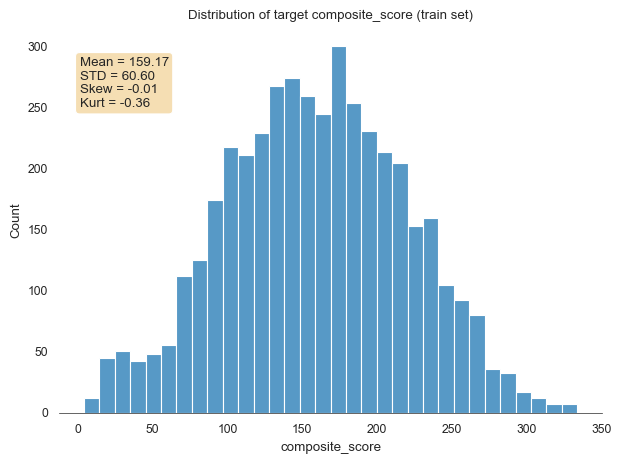

In [353]:
# Visualise y

plt.figure(figsize=(7,5))
plt.title(f'Distribution of target composite_score (train set)')
sns.histplot(x=y_train)
sns.despine(top=True, left=True, right=True, bottom=False)

txt = 'Mean = {:.2f}\nSTD = {:.2f}\nSkew = {:.2f}\nKurt = {:.2f}'.format(y_train.mean(), y_train.std(), y_train.skew(), y_train.kurt())
plt.text(1, 250, txt, bbox=plt_box_props)
plt.show()

So we have a near-normal distribution, albeit with some interesting peaks. What are the key stats?

### Feature distributions

What about the features? I won't plot them all here, to save space (although I have done this elsewhere!) But I will plot just a few features of particular interest, so we can see how their distributions look across the dataset, and also their link to composite score.

We'll need to combine X and y against to visualise some of these...

In [358]:
analysis = X_train.copy()
analysis['composite_score'] = y_train

In [359]:
def plot_feature(data, feature1, feature2):

    plt.figure(figsize=(10, 4))
    # plt.title(feature)
    
    ax = plt.subplot(1, 2, 1)
    sns.histplot(data, x=feature1)
    sns.despine(top=True, left=True, right=True)
    ax.set_xlabel('Distribution of ' + feature1)

    ax = plt.subplot(1, 2, 2)
    sns.histplot(data, x='composite_score', bins=25, kde=True, multiple='dodge', hue=feature2)
    sns.despine(top=True, left=True, right=True)
    ax.set_xlabel('Distribution of composite score by ' + feature2)

    plt.show()

First let's have a look at gender

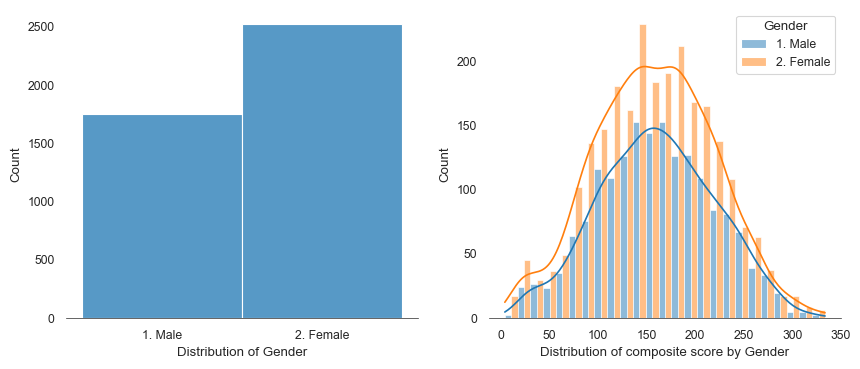

In [361]:
plot_feature(analysis, 'Gender', 'Gender')

We have approx 50% more females in the training data than males, which is interesting - and also potentially problematic.

Among protected characteristics, the only other factor we have covered is familial status:

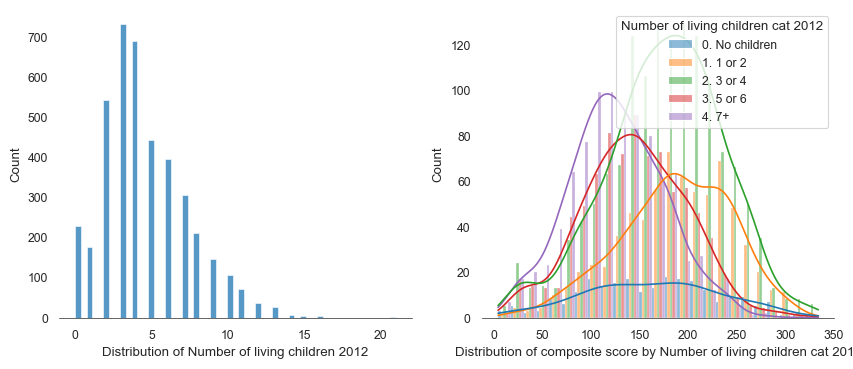

In [364]:
plot_feature(analysis, 'Number of living children 2012', 'Number of living children cat 2012')

Looking now to some of the expected important factors in cognitive capacity:

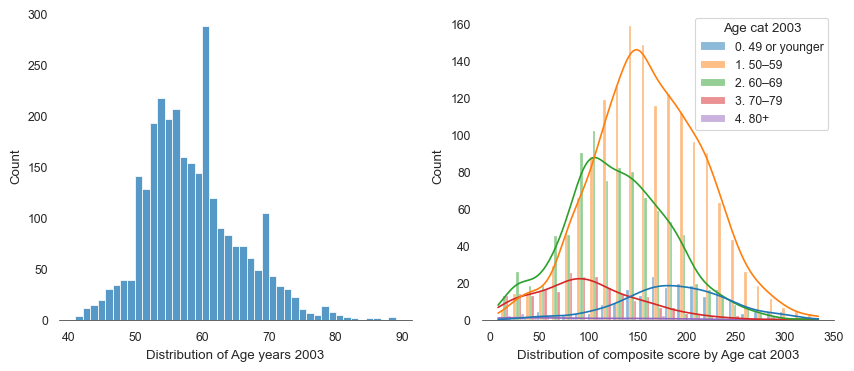

In [366]:
plot_feature(analysis, 'Age years 2003', 'Age cat 2003')

We see that age has a very distorted distribution, which an artefact of the focus of the study.
We also see a clear link between age and cognitive capacity, which is measured by composite score.

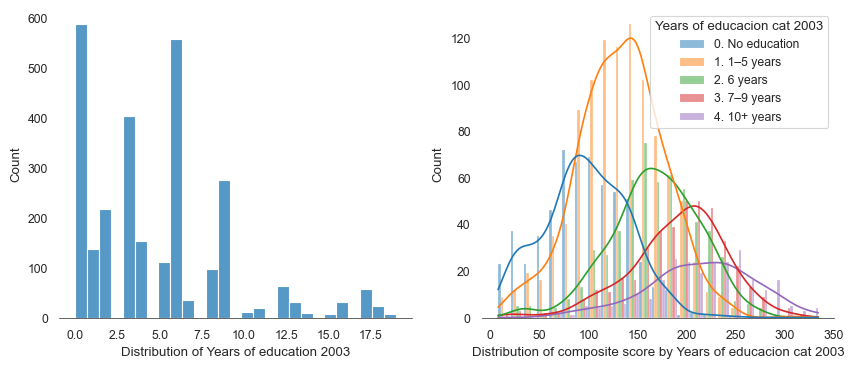

In [368]:
plot_feature(analysis, 'Years of education 2003', 'Years of educacion cat 2003')

We see that years of education has a very strong link to composite score. 

#### Which are the potentially important features?

We'll need numeric values for the categories to understand their variance...

In [372]:
X_train_numeric = convert_to_numerical(X_train)

Which features have the highest variance?

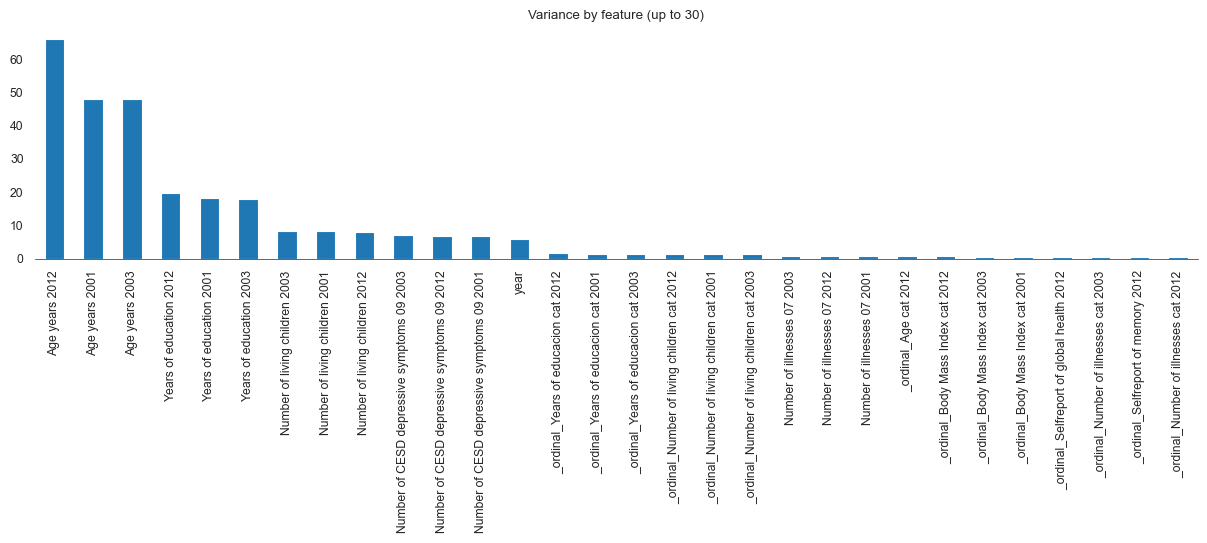

In [374]:
X_train_numeric.var().sort_values(ascending=False).head(30).plot.bar(title='Variance by feature (up to 30)', figsize=(15, 3))
sns.despine(top=True, left=True, right=True, bottom=False)
plt.show()

Age, years of education, number of children and depression have the highest variance in all survey years.

Which features correlate most to the target variable?

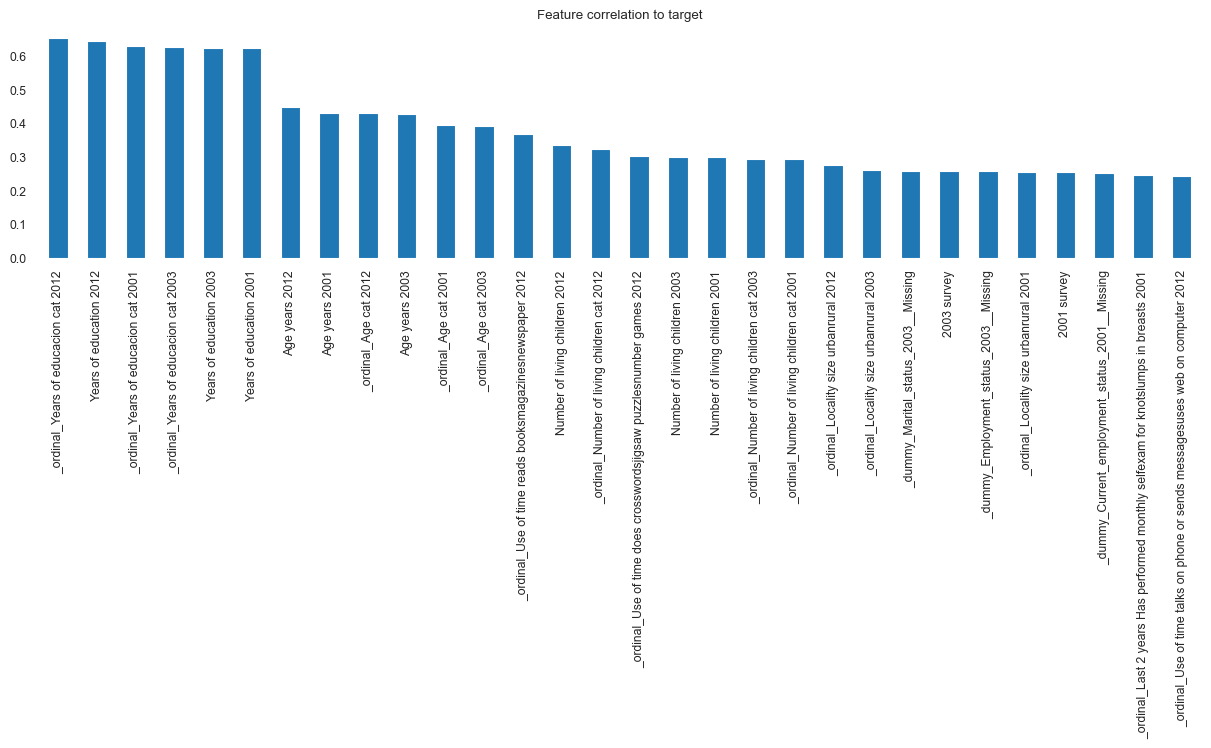

In [377]:
correlations = X_train_numeric.corrwith(y_train).dropna().abs().sort_values(ascending=False)
ax = correlations.head(30).plot.bar(title=f'Feature correlation to target', figsize=(15, 3))
sns.despine(top=True, left=True, right=True, bottom=True)
plt.show()

Education, age, reading, number of living children in all survey years have the highest correlation to the target. Interestingly we see that where people live, marital status and which surveys they were involved in also do.

## Principle component analysis

Before we start modelling, let's also explore some principal component analysis, to see if this can help us to reduce dimensionality, capturing the variance in the data in a smaller number of features...

In [381]:
from sklearn.decomposition import PCA

Fit the PCA and extract the data

In [383]:
pca_n_components = len(X_train_numeric.columns)
pca = Pipeline(steps=[
    ('imputer', SimpleImputer(missing_values=np.nan, strategy='constant', fill_value=0, add_indicator=True)),
    ('scaler', StandardScaler()),
    ('pca', PCA(n_components=len(X_train_numeric.columns), random_state=SEED))
])
pca.set_output(transform='pandas')
pca.fit(X_train_numeric)

var = pca.named_steps['pca'].explained_variance_ratio_
var_explained = np.zeros(pca_n_components)
for i in range(pca_n_components):
    var_explained[i] = sum(var[:i+1])

Visualise with a scree plot:

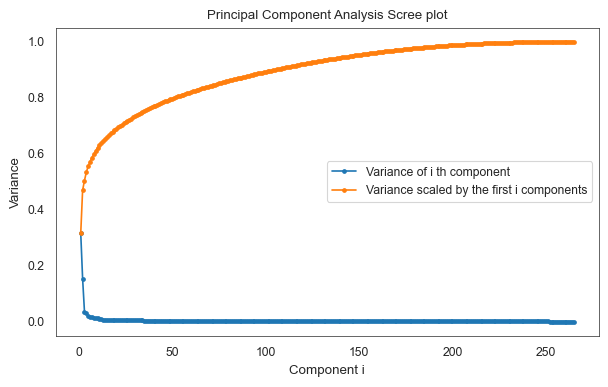

In [385]:
plt.figure(figsize = (7,4))
plt.plot(range(1, len(var_explained)+1), var, label = "Variance of i th component", marker = ".")
plt.plot(range(1, len(var_explained)+1), var_explained, label = "Variance scaled by the first i components", marker = ".")
plt.xlabel("Component i")
plt.ylabel("Variance")
plt.title("Principal Component Analysis Scree plot")
plt.legend()
plt.show()

There is no especially sharp elbow here, but we can identify the number of components we would need to capture x% of the variance in the data:

In [387]:
pca_threshold = .99
pca_n_components = next(i[0]+1 for i in enumerate(var_explained) if i[1] > pca_threshold)

pca.named_steps['pca'].set_params(n_components=pca_n_components)
pca.fit(X_train_numeric)

X_train_pca = pca.transform(X_train_numeric)

print(f'We need {X_train_pca.shape[1]} components to capture {pca_threshold*100}% of the variance\n')

X_train_pca.head(4)

We need 215 components to capture 99.0% of the variance



,pca0,pca1,pca2,pca3,pca4,pca5,pca6,pca7,pca8,pca9,...,pca205,pca206,pca207,pca208,pca209,pca210,pca211,pca212,pca213,pca214
0,-9.527334,-3.975684,6.240179,-4.143879,9.064148,-1.745655,-2.641611,2.209621,-1.571940,1.756333,...,0.070682,0.443851,0.516840,-0.297320,0.105579,-0.380122,-0.352993,0.398380,0.042785,0.421722
1,-6.183960,-2.226122,-0.305922,-0.710148,-0.450510,-6.513263,-0.219436,-3.922387,5.373232,3.614798,...,-0.376472,0.866488,-0.286412,-0.398806,-0.034749,0.009302,-0.161989,-0.413699,-0.255307,0.279557
2,17.845525,-0.537661,1.350230,0.358453,-2.692189,0.587093,0.674582,1.179015,1.185998,-0.251567,...,0.090457,-0.123744,0.300455,-0.194875,-0.360965,0.240703,-0.051260,-0.003512,0.124840,0.073750
3,17.839267,-0.531357,1.337833,0.361539,-2.717801,0.563270,0.689112,1.162229,1.198995,-0.301697,...,0.094629,-0.129137,0.318068,-0.192766,-0.354751,0.246747,-0.040913,0.012743,0.123707,0.072547


It's a reduction in dimensionality, but not much. But we evaluate whether this helps in our modelling pipeline, by adding ```("pca", pca)``` to the pipeline steps.

## Modelling

We'll store our candidate models here, indexed by name:

In [391]:
models = {}

We're using RMSE as our main metric. We need to group k-fold in cross validation, on uid:

In [393]:
cv_metric = 'neg_root_mean_squared_error'
cv_k = 5
cv = GroupKFold(cv_k)

### General modelling functions

Encapsulating some regularly used functions to keep the code clean.

In [396]:
def format_cv_result(name, cv_result, as_dataframe=False):
    """Function to standardise formatting of CV results returned by cross_validate()
    """
    r = {
        'model': name,
        'test_score': -cv_result['test_score'].mean(),
        'train_score': -cv_result['train_score'].mean(),
        'test_std': cv_result['test_score'].std(),
        'train_std': cv_result['train_score'].std(),
        'fit_time': cv_result['fit_time'].mean(),
        'score_time': cv_result['score_time'].mean(),
    }
    if as_dataframe:
        return pd.DataFrame([r])
    return r

### Naive estimator

Let's start with a naive estimator, where we just predict the mean composite_score for everyone. What does our performance on this look like?

In [399]:
models['Dummy'] = DummyRegressor(strategy='mean')

In [400]:
print(
    'Naive RMSE:',
    -cross_val_score(models['Dummy'], X_train, y_train, groups=uid_train, scoring=cv_metric, cv=cv).mean()
)

Naive RMSE: 60.589275147576544


So our goal is to predict better than this, and ideally significantly so.

### Candidate estimators

Our data is complex, high dimensional, and includes a mix of numeric and categorical types. Let's evaluate a range of suitable models for this data.

We'll start with defaults or sensible initial hyperparam values, and then tune them later. We wrap all our regressors in an sklearn pipeline, since some need data prep steps and we want to have a common interface for tuning them.

#### Gradient boosting models

##### HistGradientBoostingRegressor

In [406]:
models['HGBR'] = Pipeline(steps=[
    ('estimator', HistGradientBoostingRegressor(random_state=SEED))
])

In [407]:
-cross_val_score(models['HGBR'], X_train, y=y_train, scoring=cv_metric, groups=uid_train, cv=cv).mean()

39.8667202059688

##### LightGBM

In [409]:
models['LGBM'] = Pipeline(steps=[
    ('estimator', lgb.LGBMRegressor(metric='RMSE', random_state=SEED, verbosity=-1))
])

In [410]:
-cross_val_score(models['LGBM'], X_train, y=y_train, scoring=cv_metric, groups=uid_train, cv=cv).mean()

39.85750304672026

##### XGBoost

In [ ]:
xgb.set_config(verbosity=0)

models['XGBoost'] = Pipeline(steps=[
    ('estimator', xgb.XGBRegressor(eval_metric=root_mean_squared_error, random_state=SEED, verbosity=0, enable_categorical=True))
])

In [413]:
-cross_val_score(models['XGBoost'], X_train, y=y_train, scoring=cv_metric, groups=uid_train, cv=cv).mean()

41.948815155029294

##### CatBoost

In [642]:
# Catboost does not support NaNs in categories
# so we define a transformer to replace them with 'Missing' and include this in CBR pipeline

def catboost_transform(X):
    for col in X.select_dtypes(include=['category']):
        X[col] = X[col].astype('object').fillna('Missing').astype('category')

    return X

models['CatBoost'] = Pipeline(steps=[
    ('prep', FunctionTransformer(catboost_transform)),
    ('estimator', CatBoostRegressor(
        loss_function='RMSE', random_seed=SEED, verbose=False,
        cat_features = list(X_train.select_dtypes(include=['category'])),
        leaf_estimation_iterations=1 # trying to speed it up
    ))
])

In [ ]:
# too slow
# -cross_val_score(models['CatBoost'], X_train, y=y_train, scoring=cv_metric, groups=uid_train, cv=cv).mean()

#### Tree based models

RF and ET are extremely slow and do not exceed the above in performance, so I have not included them.

##### Decision Trees
Let's double check the simplest implementation and see how well it works

In [420]:
# requires numeric data

models['DecisionTree'] = Pipeline(steps=[
    ('features', numerical_transformer),
    ('imputer', impute_with_missing_indictators_transformer),
    ('estimator', DecisionTreeRegressor(random_state=SEED))
])

In [421]:
-cross_val_score(models['DecisionTree'], X_train, y=y_train, scoring=cv_metric, groups=uid_train, cv=cv).mean()

59.5845565268706

#### Linear models

##### LinearRegression

In [424]:
# requires numeric data

models['Linear'] = Pipeline(steps=[
    ('features', numerical_transformer),
    ('imputer', impute_with_missing_indictators_transformer),
    ('scaler', StandardScaler()),
    ('estimator', LinearRegression())
])

In [425]:
-cross_val_score(models['Linear'], X_train, y=y_train, scoring=cv_metric, groups=uid_train, cv=cv).mean()

45.04223275814657

##### Ridge

In [427]:
# requires numeric data

models['Ridge'] = Pipeline(steps=[
    ('features', numerical_transformer),
    ('imputer', impute_with_missing_indictators_transformer),
    ('scaler', MinMaxScaler()),
    ('estimator', Ridge(random_state=SEED))
])

In [428]:
-cross_val_score(models['Ridge'], X_train, y=y_train, scoring=cv_metric, groups=uid_train, cv=cv).mean()

41.62472845751712

In [429]:
models['Ridge-PCA'] = Pipeline(steps=[
    ('features', numerical_transformer),
    ('imputer', impute_with_missing_indictators_transformer),
    ('scaler', MinMaxScaler()),
    ('pca', PCA(pca_n_components)),
    ('estimator', Ridge(random_state=SEED))
])

In [430]:
-cross_val_score(models['Ridge-PCA'], X_train, y=y_train, scoring=cv_metric, groups=uid_train, cv=cv).mean()

40.79002239504477

##### Stochastic Gradient Descent
Fast and suitable for large datasets - read https://scikit-learn.org/stable/modules/sgd.html

In [432]:
# regularized linear models with stochastic gradient descent (SGD) learning
# default SGB is an SVM
# very fast, efficient and scalable
# only works with numeric data
# Sensitive to data scaling
# requires numeric data

models['SGD'] = Pipeline(steps=[
    ('features', numerical_transformer),
    ('imputer', impute_with_missing_indictators_transformer),
    ('scaler', MinMaxScaler()),
    ('estimator', SGDRegressor(random_state=SEED,early_stopping=True))
])

In [433]:
-cross_val_score(models['SGD'], X_train, y=y_train, scoring=cv_metric, groups=uid_train, cv=cv).mean()

41.41341684470702

Let's also see if PCA helps here:

In [435]:
models['SGD-PCA'] = Pipeline(steps=[
    ('features', numerical_transformer),
    ('imputer', impute_with_missing_indictators_transformer),
    ('scaler', MinMaxScaler()),
    ('pca', PCA(pca_n_components)),
    ('estimator', SGDRegressor(random_state=SEED,early_stopping=True))
])

In [436]:
-cross_val_score(models['SGD-PCA'], X_train, y=y_train, scoring=cv_metric, groups=uid_train, cv=cv).mean()

40.8173944602886

#### Neural Networks

I've been unable to get Torch to work on this tabular daata - it crashes on optimizer.step()causing a kernel restart immediately its called. It is said to be a memory error, but I have not had this issue with image data. Meanwhile, I want to at least see what a neural network might able to achieve with this data so I experiment with sklearn's Multi-layer Perceptron:

In [438]:
# starting with quite a high learning rate as was not converging at the default 0.0001 over 200 epochs

models['NN-MLP'] = Pipeline(steps=[
    ('features', numerical_transformer),
    ('imputer', impute_with_missing_indictators_transformer),
    ('scaler', MinMaxScaler()),
    ('estimator', MLPRegressor(random_state=SEED, early_stopping=True, alpha=0.001))
])

In [439]:
-cross_val_score(models['NN-MLP'], X_train, y=y_train, scoring=cv_metric, groups=uid_train, cv=cv).mean()

/opt/anaconda3/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/neural_network/_

40.895705787736546

In [440]:
models['NN-MLP-PCA'] = Pipeline(steps=[
    ('features', numerical_transformer),
    ('imputer', impute_with_missing_indictators_transformer),
    ('scaler', MinMaxScaler()),
    ('pca', PCA(pca_n_components)),
    ('estimator', MLPRegressor(random_state=SEED, early_stopping=True, alpha=0.001))
])

In [441]:
-cross_val_score(models['NN-MLP-PCA'], X_train, y=y_train, scoring=cv_metric, groups=uid_train, cv=cv).mean()

/opt/anaconda3/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


41.4396786936197

## Evaluate untuned estimators

Let's evaluate all the candidate estimators (and the dummy one) through cross validation to get an initial view of how they perform. Let's also get their predictions for each fold so we can inspect.

In [444]:
cv_results = []

In [445]:
include = models.keys() # include these models for evaluation
exclude = ['CatBoost'] # exclude these models from the loop for debugging speed

for name in include:
    if name in exclude: continue

    logger.info(f'Cross-validating {name}')

    model = models[name]
    cv_result = cross_validate(
        model, 
        X_train, 
        y_train, 
        scoring=cv_metric, 
        cv=cv,
        groups=uid_train,
        return_train_score=True
    )

    cv_results.append(format_cv_result(name, cv_result))

logger.success('Complete')

2025-04-14 00:05:35.063 | INFO     | __main__:<module>:7 - Cross-validating Dummy
2025-04-14 00:05:35.130 | INFO     | __main__:<module>:7 - Cross-validating HGBR
2025-04-14 00:05:41.782 | INFO     | __main__:<module>:7 - Cross-validating LGBM
2025-04-14 00:05:44.547 | INFO     | __main__:<module>:7 - Cross-validating XGBoost
2025-04-14 00:05:46.140 | INFO     | __main__:<module>:7 - Cross-validating DecisionTree
2025-04-14 00:05:51.687 | INFO     | __main__:<module>:7 - Cross-validating Linear
2025-04-14 00:05:58.641 | INFO     | __main__:<module>:7 - Cross-validating Ridge
2025-04-14 00:06:05.441 | INFO     | __main__:<module>:7 - Cross-validating Ridge-PCA
2025-04-14 00:06:13.274 | INFO     | __main__:<module>:7 - Cross-validating SGD
2025-04-14 00:06:20.106 | INFO     | __main__:<module>:7 - Cross-validating SGD-PCA
2025-04-14 00:06:28.185 | INFO     | __main__:<module>:7 - Cross-validating NN-MLP
/opt/anaconda3/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_percep

Let's look at the results:

In [447]:
cv_results = pd.DataFrame(cv_results)

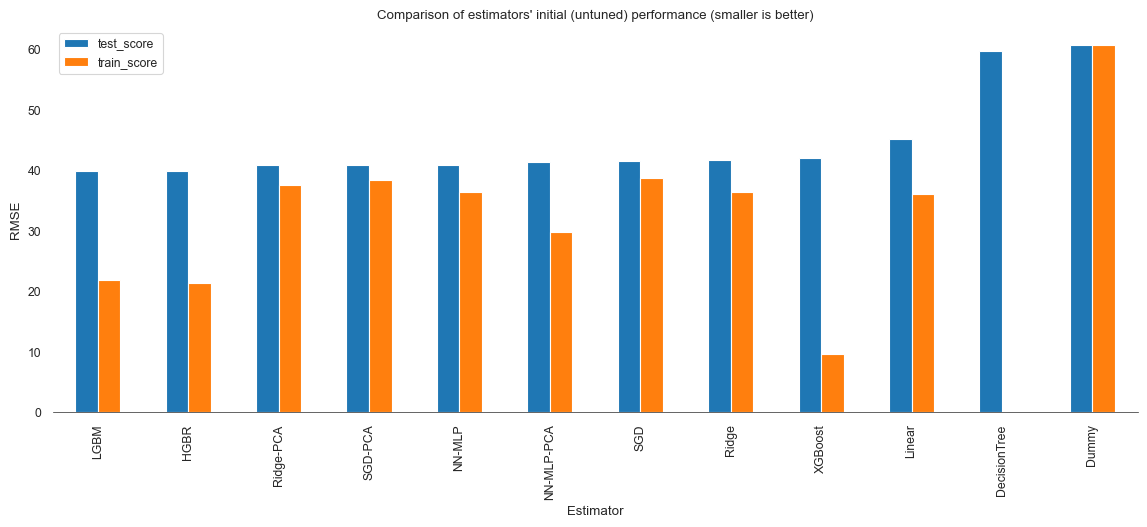

In [448]:
cv_results.set_index('model').sort_values(by='test_score')[['test_score','train_score']].plot.bar(
    figsize=(14,5),
    title='Comparison of estimators\' initial (untuned) performance (smaller is better)'
)
sns.despine(top=True, left=True, right=True, bottom=False)
plt.xlabel('Estimator')
plt.ylabel('RMSE')
plt.show()

So we see:

- Apart from Decision Tree, all the estimators are significantly better than the dummy (Naive) estimator
- LGBM and HGBR are performing best out of the box, although there is not a lot in it between all the estimators apart from Decision Tree and the Naive estimator.
- The gradient boosters are really overfitting to the training set.

Here are the numbers:

In [450]:
cv_results.sort_values(by='test_score').style.hide()

model,test_score,train_score,test_std,train_std,fit_time,score_time
LGBM,39.857503,21.740046,0.955110,0.176163,0.489432,0.034254
HGBR,39.866720,21.382270,1.026622,0.213123,1.176677,0.043719
Ridge-PCA,40.816208,37.526345,0.870993,0.212043,0.733093,0.303091
SGD-PCA,40.823090,38.334298,0.589993,0.186683,0.777430,0.334480
NN-MLP,40.895706,36.388404,0.590568,0.476205,8.915086,0.348722
NN-MLP-PCA,41.364585,29.753418,0.684516,0.918921,5.410904,0.335048
SGD,41.413417,38.727261,1.000201,0.421135,0.562880,0.329703
Ridge,41.624728,36.309863,0.684646,0.198553,0.503738,0.338300
XGBoost,41.948815,9.558642,0.843821,0.488961,0.265719,0.032211
Linear,45.042233,36.038726,4.342994,0.187562,0.601509,0.312634


## Hyperparameter tuning

To get a more useful comparison of performance, we need to tune each estimator and compare performance of the tuned estimators. The tuning approach varies by estimator. First we define a hyperparameter suggestion function for each estimator, then loop over the estimators, tuning them one by one, using Baysian Optimisation to optimise the search for the best parameters in each case.

We'll store our tuned models here:

In [454]:
tuned_models = {}

### Define hyperparameter search space

Here, for each candidate model, we define functions to return sensible initial tuning params, and the hyperparameter search space for optimisation. We prioritise the most important params for each model.

We'll store them in this dict:

In [457]:
tuners = {}

##### Dummy

We're not bothered about hyperparams for our dummy estimator, but we define empty interfaces for consistency with our modelling code.

In [460]:
def dummy_initial_tune_params(): return {}
def dummy_tune_params(trial): return {}

tuners['Dummy'] = (dummy_initial_tune_params, dummy_tune_params)

##### HGBR

In [462]:
def hgbr_initial_tune_params():
    defaults = HistGradientBoostingRegressor().get_params()
    defaults['max_depth'] = 1000 # optuna does not acccept None
    defaults['l2_regularization'] = 0.000001 # default 0 not supported for log
    params = {}
    for k in ['learning_rate', 'max_iter', 'max_leaf_nodes', 'max_depth', 'min_samples_leaf', 'l2_regularization']: # causing issues: 'max_samples', 'oob_score']:
        params['estimator__'+k] = defaults[k]
    return params

def hgbr_tune_params(trial):
    
    param_grid = {
        'estimator__learning_rate': trial.suggest_float('estimator__learning_rate', 0.001, 1, log=True), # 1 = no shrinkage
        'estimator__max_iter': trial.suggest_int('estimator__max_iter', 10, 1000, step=10), # default is 100
        'estimator__max_leaf_nodes': trial.suggest_int('estimator__max_leaf_nodes', 2, 1000), # 31 is default, None=infinite, so 1000 seems rather high; consider categorical with 'None'
        'estimator__max_depth': trial.suggest_int('estimator__max_depth', 1, 1000), # default is none but 63 seems unusually large; consider categorical with 'None'
        'estimator__min_samples_leaf': trial.suggest_int('estimator__min_samples_leaf', 2, 1000), # default is 20, but smaller needed for smaller datasets to get decent size tree
        # this could potentially be set in relation to the overall train size?
        'estimator__l2_regularization': trial.suggest_float('estimator__l2_regularization', 0.000001, 0.1, log=True), # 0 = no regularization
        'estimator__max_features': trial.suggest_float('estimator__max_features', 0.4, 1, step=0.1), # 1 is the default and maximum
        # 'estimator__max_bins': trial.suggest_int('estimator__max_bins', 63, 255), # 255 is the default and the maximum
        # IMPORTANT - this CANNOT be smaller than the max cardinality of categorical features
        # the following to be set from the data?
        # monotonic_cst
        # interaction_cst
        # consider whether to implement early stopping
    }
    return param_grid

tuners['HGBR'] = (hgbr_initial_tune_params, hgbr_tune_params)

##### LGBM

In [464]:
def lgbm_initial_tune_params():
    defaults = lgb.LGBMRegressor().get_params()
    params = {}
    for k in ['boosting_type', 'n_estimators', 'learning_rate', 'num_leaves', 
              'max_depth', 'min_child_samples', 'reg_alpha', 'reg_lambda',
              'min_split_gain', 'subsample', 'colsample_bytree' # 'subsample_freq', issues
             ]:
        params['estimator__'+k] = defaults[k]
    return params

def lgbm_tune_params(trial):
    param_grid = {
        # 'estimator__boosting_type': trial.suggest_categorical('boosting_type', ['gbdt', 'dart', 'rf']),
        'estimator__boosting_type': trial.suggest_categorical('estimator__boosting_type', ['gbdt']),
        # 'device_type': trial.suggest_categorical('estimator__device_type', ['gpu']),
        'estimator__n_estimators': trial.suggest_int('estimator__n_estimators', 50, 10000, step=50),
        'estimator__learning_rate': trial.suggest_float('estimator__learning_rate', 0.001, 1),
        'estimator__num_leaves': trial.suggest_int('estimator__num_leaves', 10, 1000), #31 is default
        'estimator__max_depth': trial.suggest_int('estimator__max_depth', -1, 500),
        'estimator__min_data_in_leaf': trial.suggest_int('estimator__min_data_in_leaf', 20, 1000),
        'estimator__lambda_l1': trial.suggest_int('estimator__lambda_l1', 0, 100, step=5),
        'estimator__lambda_l2': trial.suggest_int('estimator__lambda_l2', 0, 100, step=5),
        'estimator__min_gain_to_split': trial.suggest_float('estimator__min_gain_to_split', 5, 15),
        'estimator__bagging_fraction': trial.suggest_float('estimator__bagging_fraction', 0.5, 1.0, step=0.1),
        'estimator__bagging_freq': trial.suggest_categorical('estimator__bagging_freq', [1]),
        'estimator__feature_fraction': trial.suggest_float('estimator__feature_fraction', 0.5, 1.0, step=0.1),
    }
    return param_grid

tuners['LGBM'] = (lgbm_initial_tune_params, lgbm_tune_params)

##### XGBoost

In [494]:
def xgboost_initial_tune_params():
    # get_params doesn't return defaults, so set them here
    return {
        'estimator__tree_method': 'auto',
        'estimator__n_estimators': 100,
        'estimator__max_depth': 0,
        'estimator__learning_rate': 0.3,
        'estimator__colsample_bytree': 1,
        'estimator__subsample': 1,
        'estimator__reg_alpha': 0,
        'estimator__reg_lambda': 1,
        'estimator__gamma': 0,
        'estimator__min_child_weight': 1,
        # 'estimator__early_stopping_rounds': 100, # need to implement eval set
    }

def xgboost_tune_params(trial):
    param_grid = {
        'estimator__tree_method': trial.suggest_categorical('estimator__tree_method', ['auto', 'hist']),
        'estimator__n_estimators': trial.suggest_int('estimator__n_estimators', 10, 10000, step=10),
        'estimator__max_depth': trial.suggest_int('estimator__max_depth', 0, 16), # limiting depth often good with xgb
        'estimator__learning_rate': trial.suggest_float('estimator__learning_rate', 0.001, 1),
        'estimator__colsample_bytree': trial.suggest_float('estimator__colsample_bytree', 0.2, 1),
        'estimator__subsample': trial.suggest_float('estimator__subsample', 0.5, 1),
        'estimator__reg_alpha': trial.suggest_float('estimator__reg_alpha', 0, 10.0),
        'estimator__reg_lambda': trial.suggest_float('estimator__reg_lambda', 1e-5, 10.0, log=True),
        'estimator__gamma':trial.suggest_categorical('estimator__gamma', [0,3,6]),
        'estimator__min_child_weight': trial.suggest_int('estimator__min_child_weight', 0, 50),
        # 'estimator__early_stopping_rounds': trial.suggest_categorical('estimator__early_stopping_rounds', [100])
    }
    return param_grid

tuners['XGBoost'] = (xgboost_initial_tune_params, xgboost_tune_params)

##### CatBoost

In [468]:
def catboost_initial_tune_params():
    return {
        'estimator__nan_mode': 'Min',
        'estimator__iterations': 1000,
        'estimator__learning_rate': 0.3,
        'estimator__depth': 6,
        'estimator__subsample': 0.8,    
        'estimator__colsample_bylevel': 1,
        'estimator__min_data_in_leaf': 1,
        'estimator__early_stopping_rounds': 100,
    }

def catboost_tune_params(trial):
    param_grid = {
        'estimator__nan_mode': trial.suggest_categorical('estimator_nan_mode', ['Min']),
        'estimator__iterations': trial.suggest_int('estimator__iterations', 10, 5000, step=10),
        'estimator__learning_rate': trial.suggest_float('estimator__learning_rate', 0.001, 1),
        'estimator__depth': trial.suggest_int('estimator__depth', 1, 16),
        'estimator__subsample': trial.suggest_float('estimator__subsample', 0.5, 1),
        'estimator__colsample_bylevel': trial.suggest_float('estimator__colsample_bylevel', 0.2, 1),
        'estimator__min_data_in_leaf': trial.suggest_int('estimator__min_data_in_leaf', 0, 100),
        'estimator__early_stopping_rounds': trial.suggest_categorical('estimator__early_stopping_rounds', [100])
    }
    return param_grid

tuners['CatBoost'] = (catboost_initial_tune_params, catboost_tune_params)

##### Decision Tree

In [470]:
def decisiontree_initial_tune_params():
    defaults = DecisionTreeRegressor().get_params()
    defaults['max_depth'] = 1000 # optuna does not acccept None
    params = {}
    for k in ['criterion', 'max_depth', 'min_samples_split', 'min_samples_leaf']:
        params['estimator__'+k] = defaults[k]
    return params

def decisiontree_tune_params(trial):
    return {
        # DT tuning params
        'estimator__criterion': trial.suggest_categorical('estimator__criterion', ['squared_error', 'friedman_mse', 'absolute_error', 'poisson']),
        'estimator__max_depth': trial.suggest_int('estimator__max_depth', 2, 1000),
        'estimator__min_samples_split': trial.suggest_int('estimator__min_samples_split', 2, 2000, log=True),
        'estimator__min_samples_leaf': trial.suggest_int('estimator__min_samples_leaf', 1, 1000, log=True),
        # min_weight_fraction_leaf
        # max_features
        # max_leaf_nodes
        # min_impurity_decrease
    }

tuners['DecisionTree'] = (decisiontree_initial_tune_params, decisiontree_tune_params)

##### Multi Layer Perceptron

In [517]:
def nnmlp_initial_tune_params():
    defaults = MLPRegressor().get_params()
    params = {}
    for k in ['solver', 'alpha', 'activation']: # 'hidden_layer_sizes'
        params['estimator__'+k] = defaults[k]
    return params

def nnmlp_tune_params(trial):
    # optuna does not support arrays for suggest categorical, so need to work around this
    # layer_sizes = trial.suggest_categorical('estimator__hidden_layer_sizes', [
    #     [128],
    #     [128, 32],
    #     [256, 32],
    #     [256, 64],
    #     [256, 128, 64],
    #     [256, 128, 64, 32],
    # ])
    return {
        # 'estimator__hidden_layer_sizes': [128, 32],
        'estimator__activation': trial.suggest_categorical('estimator__activation', ['tanh', 'relu']),
        'estimator__solver': trial.suggest_categorical('estimator__solver', ['lbfgs', 'sgd', 'adam']),
        'estimator__alpha': trial.suggest_float('estimator__alpha', 1e-4, 0.1, log=True),
    }

tuners['NN-MLP'] = (nnmlp_initial_tune_params, nnmlp_tune_params)

In [527]:
def nnmlp_pca_initial_tune_params():
    params = {}
    params['pca__n_components'] = pca_n_components
    return params

def nnmlp_pca_tune_params(trial):
    params = {}
    params['pca__n_components'] = trial.suggest_int('pca__n_components', 200, 260)
    return params

tuners['NN-MLP-PCA'] = (nnmlp_pca_initial_tune_params, nnmlp_pca_tune_params)

##### Linear

We don't have any params to tune for linear regression, but we could look to tune some of the pre-processing.

In [475]:
def lr_initial_tune_params():
    return {}

def lr_tune_params(trial):
    return {}

tuners['Linear'] = (lr_initial_tune_params, lr_tune_params)

##### Ridge

In [ ]:
def ridge_initial_tune_params():
    return {
        'estimator__alpha': 1,
        # 'estimator__max_iter': 10000, # really needs to depend on solver, which is auto by default - better to allow auto
    }

def ridge_tune_params(trial):
    return {
        'estimator__alpha': trial.suggest_float('estimator__alpha', 1e-8, 10, log=True),
        # 'estimator__max_iter': trial.suggest_float('estimator__max_iter', 1000, 50000),
    }

tuners['Ridge'] = (ridge_initial_tune_params, ridge_tune_params)

In [513]:
def ridge_pca_initial_tune_params():
    params = ridge_initial_tune_params()
    params['pca__n_components'] = pca_n_components
    return params

def ridge_pca_tune_params(trial):
    params = ridge_tune_params(trial)
    params['pca__n_components'] = trial.suggest_int('pca__n_components', 200, 260)
    return params

tuners['Ridge-PCA'] = (ridge_pca_initial_tune_params, ridge_pca_tune_params)

##### Stochastic Gradient Descent

In [479]:
def sgd_initial_tune_params():
    defaults = SGDRegressor().get_params()
    params = {}
    for k in ['loss', 'penalty', 'alpha', 'l1_ratio', 'fit_intercept', 'max_iter', 'tol']:
        params['estimator__'+k] = defaults[k]
    return params
    
def sgd_tune_params(trial):
    return {
        'estimator__loss': trial.suggest_categorical('estimator__loss', ['squared_error', 'huber', 'epsilon_insensitive', 'squared_epsilon_insensitive']),
        'estimator__penalty': trial.suggest_categorical('estimator__penalty', ['l2', 'l1', 'elasticnet']),
        'estimator__alpha': trial.suggest_float('estimator__alpha', 1e-10, 10, log=True),
        'estimator__l1_ratio': trial.suggest_float('estimator__l1_ratio', 0, 1), # only applies to elasticnet, fixing here for expediency
        'estimator__fit_intercept': trial.suggest_categorical('estimator__fit_intercept', [True, False]),
        'estimator__max_iter': trial.suggest_int('estimator__max_iter', 100, 10000),
        'estimator__tol': trial.suggest_float('estimator__tol', 1e-10, 1, log=True),
        # there are a few more params to consider
    }

tuners['SGD'] = (sgd_initial_tune_params, sgd_tune_params)

In [523]:
def sgd_pca_initial_tune_params():
    params = sgd_initial_tune_params()
    params['pca__n_components'] = pca_n_components
    return params

def sgd_pca_tune_params(trial):
    params = sgd_tune_params(trial)
    params['pca__n_components'] = trial.suggest_int('pca__n_components', 200, 260)
    return params

tuners['SGD-PCA'] = (sgd_pca_initial_tune_params, sgd_pca_tune_params)

### Tuning functions

We use Optuna to orchestrate tuning with Bayesian Optimisation. We define some wrapper functions to do it nicely with our setup here, saving the tuning for each model to file as we go, to save time.

In [482]:
# keep note of studies

studies = {}

In [483]:
def get_study_path(name):
    """
    Returns the path to the file of saved studies for the model, so we can warm start.
    """
    return tuning_dir + '/' + name + '.pkl'

In [484]:
def get_study(name):
    """
    Loads and returns the Optuna study from file for the named model,
    or False if there is none.
    """
    study_path = get_study_path(name)
    if os.path.isfile(study_path):
        study = joblib.load(study_path)
        return study
    return False

In [485]:
def tune_model(name, X, y, groups, n_trials, set_best_params=True, continue_previous=True):
    """
    Tunes (or continues tuning) the name model on X and y for n_trials
    and updates model with best found params.
    The tuned model is stored in tuned_models[name].
    To restart tuning afresh, set continue_previous=False or use retune_model().
    Returns the Optuna study for the model.
    """
    
    if name not in tuned_models.keys() or tuned_models[name] is None:
        tuned_models[name] = clone(models[name])
        
    model = tuned_models[name]
    initial_params, tune_params = tuners[name]
    study = run_study(name, tune_params, X, y, groups, n_trials, continue_previous=continue_previous, initial_params_func=initial_params)
    
    if set_best_params:
        tuned_models[name].set_params(**study.best_params)
    
    return study

In [486]:
def retune_model(name, X, y, groups, n_trials, set_best_params=True):
    """
    Restarts tuning the name model. Clears prior study and calls tune() to start a new one.
    """
    tuned_models[name] = None
    return tune_model(name, X, y, groups, n_trials, set_best_params=set_best_params, continue_previous=False)

In [487]:
# optuna.logging.set_verbosity(optuna.logging.WARNING)
optuna.logging.set_verbosity(optuna.logging.INFO)

# todo: implement this
from optuna.integration import LightGBMPruningCallback

def run_study(name, param_grid_func, X, y, groups, n_trials=None, continue_previous=False, initial_params_func=None):
    """
    Runs an Optuna study for the named model.
    """

    logger.info('Tuning ' + name)

    # define the objective function
    def objective(trial, model, param_grid_func, X, y, groups):
        """
        Objective function this Optuna study
        """
    
        # use a clone of the model so we do not prevent the original from being re-used
        # if this does not work with a non sklearn model try .deepcopy()
        model = clone(model)

        # set the trial params
        param_grid = param_grid_func(trial)
        model.set_params(**param_grid)

        # get the score from cv
        scores = cross_val_score(model, X, y=y, groups=groups, cv=cv, scoring=cv_metric)
        return -scores.mean()

    # model
    model = models[name]

    # resume existing study or start a new one?
    study_path = get_study_path(name)
    if continue_previous and os.path.isfile(study_path):
        study = joblib.load(study_path)
        logger.info(f'Resuming existing study from file (previous best {study.best_trial.value})')
    else:
        logger.info('Starting new study')
        study = optuna.create_study(direction='minimize', study_name=name)
        if initial_params_func is not None:
            study.enqueue_trial(initial_params_func())

    # run the study
    func = lambda trial: objective(trial, model, param_grid_func, X, y, groups)
    study.optimize(func, n_trials=n_trials) # show_progress_bar=True not working

    # save it - todo: better to save after each trial, in case we have issues
    joblib.dump(study, study_path)
    logger.info('Study saved to file')

    # output results & reports
    # print(f"\tBest value ({cv_metric}): {study.best_value:.5f}")
    # print(f"\tBest params:")
    # for key, value in study.best_params.items():
    #     print(f"\t\t{key}: {value}")

    # return
    return study

### Let's do the tuning

In [650]:
n_trials_per_batch = 5 # set low because many trials already carried out 
n_batches_per_model = 10
include = models.keys() # include these models for this tuning round
exclude = ['Dummy', 'CatBoost', 'NN-MLP', 'DecisionTree'] # exclude these models from this tuning round

for name in include:
    if name in exclude: continue

    for i in range(n_batches_per_model):
        tune_model(name, X_train, y_train, uid_train, n_trials_per_batch)

logger.success('Complete')

2025-04-14 00:44:09.310 | INFO     | __main__:run_study:12 - Tuning Dummy
2025-04-14 00:44:09.318 | INFO     | __main__:run_study:39 - Resuming existing study from file (previous best 60.589275147576544)
[I 2025-04-14 00:44:09,371] Trial 58 finished with value: 60.589275147576544 and parameters: {}. Best is trial 0 with value: 60.589275147576544.
[I 2025-04-14 00:44:09,404] Trial 59 finished with value: 60.589275147576544 and parameters: {}. Best is trial 0 with value: 60.589275147576544.
[I 2025-04-14 00:44:09,431] Trial 60 finished with value: 60.589275147576544 and parameters: {}. Best is trial 0 with value: 60.589275147576544.
[I 2025-04-14 00:44:09,459] Trial 61 finished with value: 60.589275147576544 and parameters: {}. Best is trial 0 with value: 60.589275147576544.
[I 2025-04-14 00:44:09,486] Trial 62 finished with value: 60.589275147576544 and parameters: {}. Best is trial 0 with value: 60.589275147576544.
2025-04-14 00:44:09.490 | INFO     | __main__:run_study:52 - Study save

### Visualise optimisation progress for each model

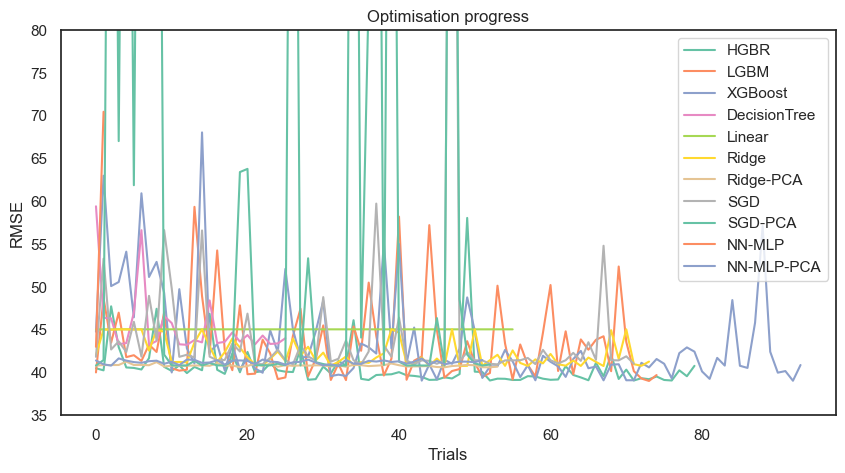

In [665]:
include = models.keys() # include these models in charge
exclude = ['Dummy'] # no benefit in plotting
optimisation = {}

for name in include:
    if name in exclude: continue
    study = get_study(name)
    if study:
        values = []
        for t in study.trials:
            values.append(t.values[0])
        optimisation[name] = values

# creating DF out of arrays with different lengths, yukky but true
optimisation = pd.DataFrame(dict([(k,pd.Series(v)) for k,v in optimisation.items()]))

optimisation.plot.line(title='Optimisation progress', figsize=(10, 5))
plt.ylabel('RMSE')
plt.xlabel('Trials')
plt.ylim(35, 80)
plt.show()

We can see that model tuning is still exploring new (and in some cases unlikely) areas of the search space. This could be improved by refining the search space manually, but it is likely that we have already found values that very near to the minima for each model, so let's progress with this for now. We can improve tuning later. 

Which estimators have the best performance with their best params?

## Evaluate tuned estimators

Now we've tuned all our models, we can compare them more effectively...

In [669]:
include = tuned_models.keys() # include these models for evaluation
exclude = ['CatBoost', 'DecisionTree'] # exclude these models from the loop for speed

cv_results = []

for name in include:
    if name in exclude: continue

    logger.info(f'Cross-validating tuned {name}')

    model = tuned_models[name]
    cv_result = cross_validate(model, 
        X_train, 
        y_train, 
        scoring=cv_metric, 
        cv=cv,
        groups=uid_train,
        return_train_score=True
    )

    cv_results.append(format_cv_result(name, cv_result))

logger.success('Complete')

2025-04-14 07:17:10.252 | INFO     | __main__:<module>:9 - Cross-validating tuned Dummy
2025-04-14 07:17:10.318 | INFO     | __main__:<module>:9 - Cross-validating tuned HGBR
2025-04-14 07:17:37.891 | INFO     | __main__:<module>:9 - Cross-validating tuned LGBM
2025-04-14 07:17:45.287 | INFO     | __main__:<module>:9 - Cross-validating tuned XGBoost
2025-04-14 07:18:13.906 | INFO     | __main__:<module>:9 - Cross-validating tuned Linear
2025-04-14 07:18:20.774 | INFO     | __main__:<module>:9 - Cross-validating tuned Ridge
2025-04-14 07:18:27.176 | INFO     | __main__:<module>:9 - Cross-validating tuned Ridge-PCA
2025-04-14 07:18:34.776 | INFO     | __main__:<module>:9 - Cross-validating tuned SGD-PCA
2025-04-14 07:18:42.582 | INFO     | __main__:<module>:9 - Cross-validating tuned NN-MLP-PCA
2025-04-14 07:19:00.848 | INFO     | __main__:<module>:9 - Cross-validating tuned SGD
2025-04-14 07:19:07.824 | SUCCESS  | __main__:<module>:23 - Complete


Let's look at the results:

In [670]:
cv_results = pd.DataFrame(cv_results)

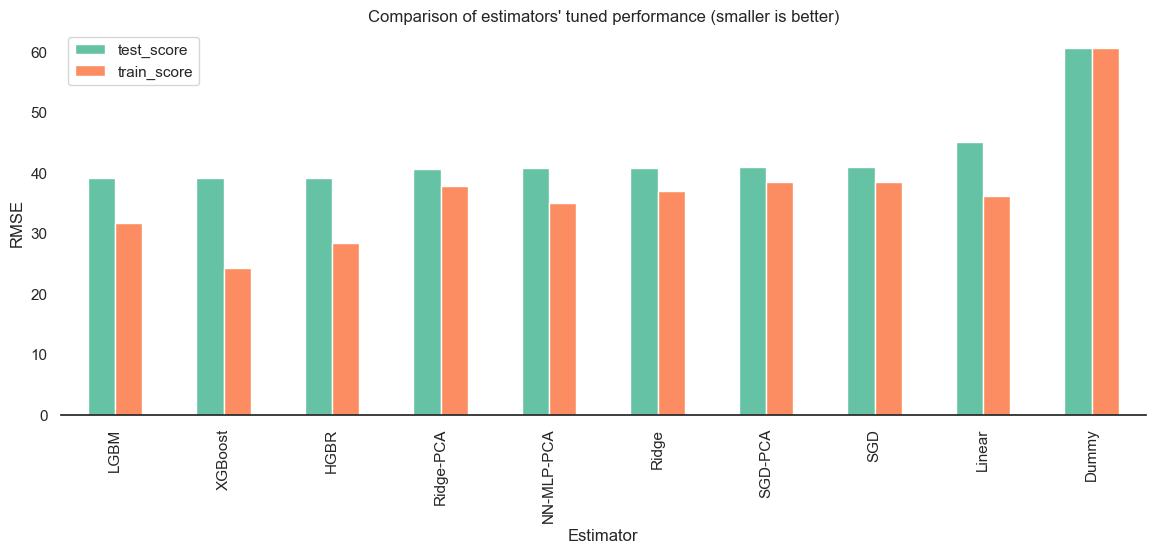

In [671]:
cv_results.set_index('model').sort_values(by='test_score')[['test_score','train_score']].plot.bar(
    figsize=(14,5),
    title='Comparison of estimators\' tuned performance (smaller is better)'
)
sns.despine(top=True, left=True, right=True, bottom=False)
plt.xlabel('Estimator')
plt.ylabel('RMSE')
plt.show()

In [672]:
cv_results.sort_values(by='test_score').style.hide()

model,test_score,train_score,test_std,train_std,fit_time,score_time
LGBM,39.009212,31.725458,0.998669,0.201201,1.363745,0.068080
XGBoost,39.034283,24.245024,0.997035,0.167314,5.555905,0.046450
HGBR,39.061375,28.352616,1.073232,0.215833,5.266331,0.071988
Ridge-PCA,40.594321,37.687854,0.885823,0.218723,0.725335,0.317693
NN-MLP-PCA,40.743034,34.984141,0.891066,1.261084,2.873828,0.319450
Ridge,40.749941,36.892344,0.746223,0.202893,0.470562,0.306401
SGD-PCA,40.817680,38.342477,0.592717,0.192662,0.705367,0.362454
SGD,40.945712,38.454754,0.636602,0.475398,0.578730,0.339365
Linear,45.042233,36.038726,4.342994,0.187562,0.575488,0.344939
Dummy,60.589275,60.592470,1.320286,0.328045,0.007332,0.000402


So we can see from this that:

- Hyperparameter tuning has helped to improve performance across the board
- In particular we can see that the gradient boosters have benefitted and are leading the board
- XGBoost has seen the largest improvement
- But we can see likely overfitting in their better performance on the train folds

## Ensemble

We can select our top n estimators by performance - or select them manual based on other factors, such as explainability - and then and combine them in an ensemble to leverage their relative strengths and increase robustness to new data.

We could tune the number of estimators in the ensemble and their relative weights, but for now we will fix these.

In [676]:
n_estimators = 3

In [677]:
top_estimators = list(cv_results.sort_values(by='test_score').head(n_estimators)['model'])

Construct the ensemble and see its architecture:

In [679]:
ensemble_estimators = [
    (name, tuned_models[name]) for name in top_estimators
]
ensemble = VotingRegressor(estimators=ensemble_estimators)
ensemble

VotingRegressor(estimators=[('LGBM',
                             Pipeline(steps=[('estimator',
                                              LGBMRegressor(bagging_fraction=0.5,
                                                            bagging_freq=1,
                                                            feature_fraction=0.7,
                                                            lambda_l1=40,
                                                            lambda_l2=75,
                                                            learning_rate=0.025726430097867913,
                                                            max_depth=151,
                                                            metric='RMSE',
                                                            min_data_in_leaf=84,
                                                            min_gain_to_split=7.5882205268096286,
                                                            n_estimators=700,
                                                            num_leaves=561,
                                                            random_state=42,
                                                            verbosity=-1))])),
                            ('...
                                                           monotone_constraints=None,
                                                           multi_strategy=None,
                                                           n_estimators=1760,
                                                           n_jobs=None,
                                                           num_parallel_tree=None, ...))])),
                            ('HGBR',
                             Pipeline(steps=[('estimator',
                                              HistGradientBoostingRegressor(l2_regularization=0.01800473373175108,
                                                                            learning_rate=0.012638631627525695,
                                                                            max_depth=850,
                                                                            max_features=0.4,
                                                                            max_iter=770,
                                                                            max_leaf_nodes=736,
                                                                            min_samples_leaf=111,
                                                                            random_state=42))]))])

Let's find out how this final ensemble performs in cross-validation:

In [681]:
logger.info('Cross-validating ensemble. Results to follow...')

cv_result = cross_validate(
    ensemble, 
    X_train, 
    y_train, 
    scoring=cv_metric, 
    cv=cv,
    groups=uid_train,
    return_train_score=True
)

2025-04-14 07:19:08.247 | INFO     | __main__:<module>:1 - Cross-validating ensemble. Results to follow...


In [682]:
display(pd.DataFrame([format_cv_result('Ensemble', cv_result)]).style.hide())

model,test_score,train_score,test_std,train_std,fit_time,score_time
Ensemble,38.868193,27.947174,1.018112,0.190090,12.456280,0.206165


So our ensemble is slightly more accurate in cross validation than the individual subestimators.

## Train and test

I'm happy with this, let's train it on the train data so we can benchmark it on the test data:

### Training

In [687]:
ensemble.fit(X_train, y_train)
logger.success('Ensemble trained')

2025-04-14 07:20:27.613 | SUCCESS  | __main__:<module>:2 - Ensemble trained


As well as giving a predicted composite_score, we want to give a prediction interval, to aid with explainability to lay users - our patients. I have experimented with a number of approaches to this, including quantile regression and training a model to predict error. But here I use the MAPIE approach, set out by Christoph Molnar.

In [689]:
logger.info('Training MapieRegressor')

mapie_regressor = MapieRegressor(
    estimator=ensemble,
    method='plus',
    cv=GroupKFold(n_splits=cv_k),
    random_state=SEED
)
mapie_regressor = mapie_regressor.fit(
    X_train,
    y_train,
    groups=uid_train,
    random_state=SEED
)

logger.success('MapieRegressor trained')

2025-04-14 07:20:27.664 | INFO     | __main__:<module>:1 - Training MapieRegressor
2025-04-14 07:21:44.153 | SUCCESS  | __main__:<module>:16 - MapieRegressor trained


Now we can save the model ready for prediction, to the test model path. We'll save out the final model when we've trained it on the whole data.

In [691]:
to_save = {
    'ensemble': ensemble,
    'mapie_regressor': mapie_regressor
}

with open(test_model_path, "wb") as file:
    pickle.dump(to_save, file)

logger.success(f'Trained model saved to {test_model_path}')

2025-04-14 07:21:44.525 | SUCCESS  | __main__:<module>:9 - Trained model saved to ./models/test_model.pkl


### Test

Now we can use our trained model to predict on the test set, to get an unbiased estimate of performance:

In [694]:
def predict(
    X,
    uids,
    model_path = test_model_path,
    include_mapie = False,
):
    """Make predictions on X, using the model at model_save_path.
    Returns the predictions, optionally with MAPIE intervals
    """

    # Load model

    logger.info(f'Loading trained model from {model_path}')
    with open(model_path, "rb") as file:
        saved = pickle.load(file)

    ensemble = saved['ensemble']
    mapie_regressor = saved['mapie_regressor']
        
    # Predict

    logger.info(f'Predicting labels')
    y_pred = ensemble.predict(X)
    y_pred = y_pred.round(0).astype(int)
    pred_labels = pd.DataFrame({
        'uid': uids,
        'year': X['year'],
        'composite_score': y_pred
    })

    # MAPIE prediction intervals
    # We do not set a min of 0 here, this will to be done prior to outputting

    if include_mapie:

        logger.info(f'Predicting MAPIE intervals')
        mapie_y_pred, mapie_intervals = mapie_regressor.predict(X, alpha=[0.05, 0.2])
    
        # pred_labels['mapie_y'] = mapie_pred_y.round(0).astype(int)
        pred_labels['mapie_lower_90'] = mapie_intervals[:,0,0].round(0).astype(int)
        pred_labels['mapie_upper_90'] = mapie_intervals[:,1,0].round(0).astype(int)
        pred_labels['mapie_lower_60'] = mapie_intervals[:,0,1].round(0).astype(int)
        pred_labels['mapie_upper_60'] = mapie_intervals[:,1,1].round(0).astype(int)

    logger.success(f'Done')
    return pred_labels

Let's test prediction on the test set:

In [696]:
pred = predict(X_test, uid_test, model_path=test_model_path, include_mapie=True)

2025-04-14 07:21:44.612 | INFO     | __main__:predict:13 - Loading trained model from ./models/test_model.pkl
2025-04-14 07:21:44.958 | INFO     | __main__:predict:22 - Predicting labels
2025-04-14 07:21:45.171 | INFO     | __main__:predict:36 - Predicting MAPIE intervals
2025-04-14 07:21:46.818 | SUCCESS  | __main__:predict:45 - Done


In [697]:
print('RMSE on the test set is:', root_mean_squared_error(y_test, pred['composite_score']))

RMSE on the test set is: 38.783878938764275


How about the prediction interval?

In [699]:
print('% of predictions within 90% interval:',
    y_test.between(pred['mapie_lower_90'], pred['mapie_upper_90']).mean()
)

print('% of predictions within 60% interval:',
    y_test.between(pred['mapie_lower_60'], pred['mapie_upper_60']).mean()
)

% of predictions within 90% interval: 0.9491525423728814
% of predictions within 60% interval: 0.8088512241054614


These are probably much wider than neccessary - we should be able to improve on this.

Let's take a look at some predictions and intervals:

In [702]:
pred.head()

,uid,year,composite_score,mapie_lower_90,mapie_upper_90,mapie_lower_60,mapie_upper_60
0,11507.0_10,2021,140,65,219,92,191
1,5829.0_10,2021,161,84,239,112,210
2,11429.0_20,2021,156,79,233,107,204
3,9704.0_10,2021,98,21,174,49,146
4,6776.0_10,2021,128,51,205,79,177


## Prediction analysis

We want to understand a bit more that just what our predictions error is.
What are the areas of strong prediction, and where are predictions less accurate?
What areas do we want to improve on?

Todo - bring in my earlier analysis

First let's get the test data into a single dataframe for analysis.

In [707]:
analysis = X_test.copy()
analysis['composite_score'] = y_test
analysis = pd.concat([analysis, pred.rename(columns={'composite_score': 'pred'})], axis=1)

### Prediction accuracy

How do our predictions compare to actuals?

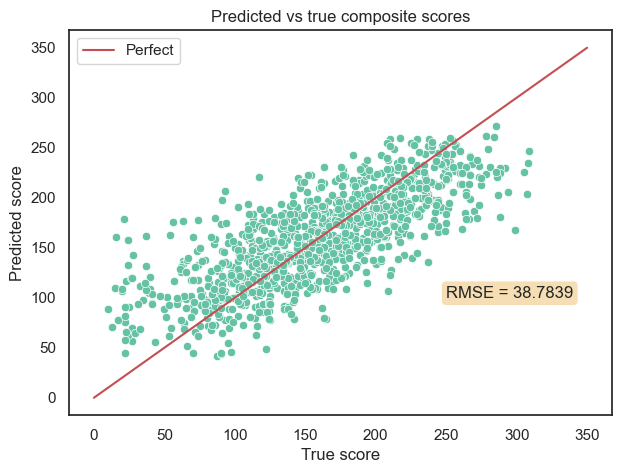

In [710]:
rmse = round(root_mean_squared_error(analysis['composite_score'], analysis['pred']), 4)

plt.figure(figsize=(7, 5))
plt.title('Predicted vs true composite scores')
sns.scatterplot(data=analysis, x='composite_score', y='pred')
plt.xlabel('True score')
plt.ylabel('Predicted score')
plt.plot([0,350], [0,350], c='r', label='Perfect')
plt.text(250, 100, f'RMSE = {rmse}', bbox=plt_box_props)
plt.legend()
plt.show()

We can see here that predictions are more accurate toward the centre of the distribution: we have a tendency to overpredict for low scorers, and underpredict for high scorers.

The underlying problem here is an imbalance in the data - we have less data for people at the edges of the distribution. We can potentially improve our predictions for low scorers by increasing the data, or by increasing sample weights to increase the impact of low scorer samples on the algorithm, potentially at the cost of a less accuracy overall prediction.

### Bias and fairness

Todo

### Prediction intervals

How do our prediction intervals compare to the predictions themselves?

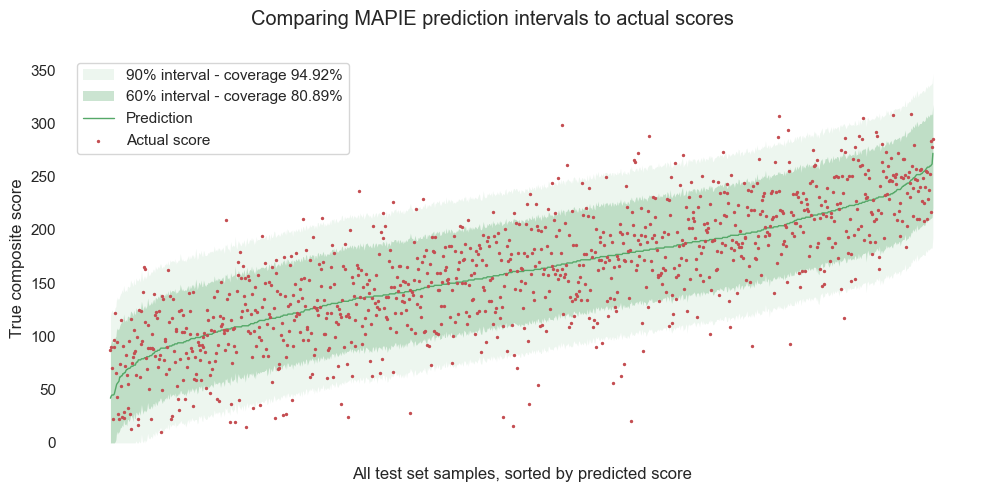

In [716]:
# visualise MAPIE

fig, ax = plt.subplots(1, 1, figsize=(10, 5), sharey=True, sharex=True)

test_intervals2 = analysis.sort_values(by='pred').reset_index()

ax.fill_between(
    x=list(test_intervals2.index),
    y1=np.maximum(test_intervals2['mapie_lower_90'].to_numpy(), 0),
    y2=np.minimum(test_intervals2['mapie_upper_90'].to_numpy(), 384), # move 384 to max score scomewhere
    alpha=0.1,
    linewidth=0,
    color='g'
)
ax.fill_between(
    x=list(test_intervals2.index),
    y1=np.maximum(test_intervals2['mapie_lower_60'].to_numpy(), 0),
    y2=np.minimum(test_intervals2['mapie_upper_60'].to_numpy(), 384), # move 384 to max score scomewhere
    alpha=0.3,
    linewidth=0,
    color='g'
)
ax.plot(
    list(test_intervals2.index),
    test_intervals2['pred'],
    linewidth=1,
    # s=1,
    alpha=1,
    color='g'
)
ax.scatter(
    x=list(test_intervals2.index),
    y=test_intervals2['composite_score'],
    alpha=1,
    s=2,
    color='r',
    zorder=100
)

ax.legend([
    '90% interval - coverage ' + \
        str(round(test_intervals2['composite_score'].between(
              test_intervals2['mapie_lower_90'], test_intervals2['mapie_upper_90']
        ).mean() * 100, 2)) + '%',
    '60% interval - coverage ' + \
        str(round(test_intervals2['composite_score'].between(
              test_intervals2['mapie_lower_60'], test_intervals2['mapie_upper_60']
        ).mean() * 100, 2)) + '%',
    'Prediction', 'Actual score'
], loc='upper left')
plt.suptitle('Comparing MAPIE prediction intervals to actual scores')
ax.set_ylabel('True composite score')
ax.set_xlabel('All test set samples, sorted by predicted score')

plt.xticks([])
sns.set_theme()
sns.set_style('white')
sns.set_palette('Set2')
sns.despine(ax=ax, left=True, bottom=True)
plt.tight_layout()
plt.show()

From this we can see that our prediction intervals and coverage are consistent through the prediction distribution, but that most of the small number of predictions falling outside of this are lower scorers who we have over-predicted for.

## Explainability

In addition to understand how our model performs, we want to be able to explain how predictions are made, and what the most important features, both at a population and individual level. I have explored a wide range of techniques for this, and present here a solution based on SHAP.

### Shap functions - in progress

We encapsulate functions here for tidiness.

In [722]:
feature_names = list(X_train.columns)

In [723]:
def shap_explanations(ensemble, X):
    """Builds and returns the SHAP explanations for the predictions.

    Called by predict()

    Args:
        ensemble (sklearn.ensemble.VotingRegressor): fitted ensemble used to make predictions
        X (pd.DataFrame): prepared X for prediction
    
    Returns:
        ensemble_explanation (shap.Explanation): SHAP Explanation object for the overall ensemble
        subestimator_explanations (Dict): a dictionary of SHAP Explanation objects for each subestimator in the ensemble, with the subestimator names as the keys
    """

    # shap doesn't support VotingRegressor
    # so we build explainers for each estimator
    # then make the ensemble calculations by hand

    sub_explanations = {}
    sub_expected_values = []
    for name, pipeline in ensemble.named_estimators_.items():

        estimator = pipeline.named_steps['estimator']
        print(estimator)
    
        explainer = shap.TreeExplainer(estimator, feature_perturbation="tree_path_dependent")
        explanation = explainer(X)
        sub_explanations[name] = explanation
        sub_expected_values.append(explainer.expected_value)
    
    # ensemble calculations
    # see:
    # https://arxiv.org/pdf/2106.08990
    # https://github.com/shap/shap/issues/112
    
    all_shap_values = [exp.values for exp in sub_explanations.values()] # the shap values from each estimator 
    ensemble_shap_values = np.mean(all_shap_values, axis=0) # an array of same shape as X with shap value for each sample and feature
    ensemble_expected_value = np.mean(sub_expected_values) # mean of mean predictions for each estimator

    # put the data in a shap.Explanation object
    # see:
    # https://shap.readthedocs.io/en/latest/generated/shap.Explanation.html#shap.Explanation
    # https://github.com/shap/shap/blob/master/shap/_explanation.py
    
    ensemble_explanation = shap.Explanation(
        values=ensemble_shap_values,
        feature_names=list(X.columns),
        data=X.to_numpy(),
        base_values=ensemble_expected_value # np.full(len(shap_feature_names), ensemble_expected_value).squeeze()
        # Due to a possible bug in the shap waterfall code
        # explanation base_values needs to be a single numeric, not a list
        # this doesn't seem to affect other functionality; but if it does, revert to a list
        # and fix for the waterfalls
        # see https://github.com/shap/shap/issues/1801
    )

    return ensemble_explanation, sub_explanations

In [724]:
def visualise_decision(
    index,
    ensemble_explanation,
    subestimator_explainations,
    show = True
):
    # Plot individual's SHAP decision charts

    nice_feature_names = [
        (feature_names[name][:20] + '...') if len(feature_names[name]) > 20 else feature_names[name]
            for name in ensemble_explanation.feature_names
    ]

    # sns.set_style('white')

    plt.figure(figsize=(5, 10))

    shap_values = [explanation.values[index] for explanation in subestimator_explainations.values()]
    shap_values = np.append(shap_values, [ensemble_explanation.values[index]], axis=0)
    highlight = [shap_values.shape[0]-1]

    # passing base_values as a list to decision_plot is currently broken
    # as workarund, values could be adjusted on the chart for the different base (expected) values for each explainer
    # but the differences are slight (<0.2) so imperceptible on the chart
    # expecteds = [exp['explainer'].expected_value for exp in explainers]
    # print(expecteds)

    legend_labels = [
        name.upper()
        for name, explanation in subestimator_explainations.items()
    ]
    
    legend_labels = [
        name.upper() + ' (' + str(round(explanation.base_values[0] + sum(explanation.values[index]), 2)) + ')'
        for name, explanation in subestimator_explainations.items()
    ] + ['Overall prediction (' + str(round(ensemble_explanation.base_values + sum(ensemble_explanation.values[index]), 0).astype('int')) + ')']

    ax = shap.decision_plot(
        ensemble_explanation.base_values,
        shap_values,
        feature_names=nice_feature_names,
        feature_display_range=slice(-1, -21, -1),
        highlight=highlight,
        title='',
        legend_labels=legend_labels,
        legend_location="lower right",
        show=False,
        auto_size_plot=False
    )
    
    ax = plt.gca()
    ax.set_xlabel('Predicted cognitive capacity')

    if show:
        plt.show()

    return plt   

### Visualising

In [726]:
# shap_explanations(ensemble, X_test)

## Final training

We can now train and save the model on all X and y, ready for real world use.

In [729]:
X = pd.concat([X_train, X_test])
y = pd.concat([y_train, y_test])
uid = pd.concat([uid_train, uid_test])

In [730]:
logger.info('Final training...')

ensemble.fit(X, y)
logger.success('Ensemble trained')

2025-04-14 07:21:47.715 | INFO     | __main__:<module>:1 - Final training...
2025-04-14 07:22:06.656 | SUCCESS  | __main__:<module>:4 - Ensemble trained


Train MAPIE on all data...

In [732]:
logger.info('Training MapieRegressor')

mapie_regressor = MapieRegressor(
    estimator=ensemble,
    method='plus',
    cv=GroupKFold(n_splits=cv_k),
    random_state=SEED
)
mapie_regressor = mapie_regressor.fit(
    X,
    y,
    groups=uid,
    random_state=SEED
)

logger.success('MapieRegressor trained')

2025-04-14 07:22:06.715 | INFO     | __main__:<module>:1 - Training MapieRegressor
2025-04-14 07:23:35.521 | SUCCESS  | __main__:<module>:16 - MapieRegressor trained


And save:

In [734]:
to_save = {
    'ensemble': ensemble,
    'mapie_regressor': mapie_regressor
}

with open(final_model_path, "wb") as file:
    pickle.dump(to_save, file)

logger.success(f'Final model saved to {final_model_path}')

2025-04-14 07:23:35.925 | SUCCESS  | __main__:<module>:9 - Final model saved to ./models/final_model.pkl


## Done!

## Todo/WIPs

- Fix Shap (issue with hgbr?)
- Fairness metrics
- Visualisation of prediction against population distribution
- Catboost - start with known good params, too slow to discover them afresh!

Experiments:

- NN constantly crashing - optimizer.step() causing kernel restart - seems to be a memory issue

For the readme:

- Need latest xgboost and sklearn - pip install xgboost==3.0.0
- Where to get daata